# Eval Model 

### Read Model CheckPoint

In [7]:
import sys
sys.path.insert(0, './FirstMultiModel/EEGART')

from transformers import Trainer, TrainingArguments

import torch
import torch.nn as nn
import numpy as np

import sys
sys.path.insert(0, './Dataloader')
import torch
from torch.utils.data import Dataset, DataLoader
from SLT_dataloader import RandonMaskDataCollator

from tf_config import SLTConfig
from tf_model import SLTModel, pre_SLTModel
from datetime import datetime

# 指定 checkpoint 的路徑
checkpoint_path = "./results_3pca/mask_tarin_with_positionalencoding__20250427_013228/checkpoint-32800"

# 載入 config
config = SLTConfig.from_pretrained(checkpoint_path)

# 載入 model
model = pre_SLTModel.from_pretrained(checkpoint_path, config=config)

# 移到 GPU（如果有的話）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


### Read Eval Dataset

In [8]:
import sys
sys.path.insert(0, './Dataloader')
from SLT_dataloader import EEGROI_Power_Dataset, EEGROI_fft_Dataset

train_10_path = "G:\\共用雲端硬碟\\CNElab_陳昱祺\\source localization\\simulate_data\\dataset_seedsource_2000_10_20250406_034254\\"

train_1_path = "G:\\共用雲端硬碟\\CNElab_陳昱祺\\source localization\\simulate_data\\dataset_seedsource_2000_1_20250406_034323\\"

train_1000000_path = "G:\\共用雲端硬碟\\CNElab_陳昱祺\\source localization\\simulate_data\\dataset_seedsource_2000_1000000.0_20250406_034224\\"

eval_path =  "G:\\共用雲端硬碟\\CNElab_陳昱祺\\source localization\\test_data\\ROI\\Desikan_Kilianny_with_3pca\\"

# Create dataset
group_file = "./Dataloader/subject_groups.json"

# Create dataset
eval_dataset = EEGROI_fft_Dataset(eval_path, eval_path, group_file, "eval_dataset" )
print(f"\n\n================================================\n")
print(f"Total dataset size: {len(eval_dataset)}")
# Create dataset
train_1_dataset = EEGROI_Power_Dataset(train_1_path)
train_10_dataset = EEGROI_Power_Dataset(train_10_path)
train_1000000_dataset = EEGROI_Power_Dataset(train_1000000_path)
# train_dataset =  EEGROI_fft_Dataset(eval_path, eval_path, group_file, "train_dataset" )
print(f"\n\n================================================\n")
print(f"Total dataset size: {len(train_1_dataset)}\n{len(train_10_dataset)}\n{len(train_1000000_dataset)}")


['194', '195', '196', '197', '198']
EEG Power shape: torch.Size([30, 100])
Source Power shape: torch.Size([204, 100])



Total dataset size: 689
EEG Power shape: torch.Size([20000, 30, 100])
Source Power shape: torch.Size([20000, 204, 100])
EEG Power shape: torch.Size([20000, 30, 100])
Source Power shape: torch.Size([20000, 204, 100])
EEG Power shape: torch.Size([20000, 30, 100])
Source Power shape: torch.Size([20000, 204, 100])



Total dataset size: 20000
20000
20000


In [9]:
import matplotlib.pyplot as plt

def show_fft(positive_power, sampling_rate = 100, x=17, y=4, z=32):

    # 只取正頻率部分
    positive_freqs = range(0, 100)

    # 畫出所有 labels 的 Power Spectrum
    fig, axes = plt.subplots(x, y, figsize=(16, z))  
    fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)
    
    for i, ax in enumerate(axes.flat):
        if i < len(positive_power):
            ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
            ax.set_title(f' Channel-{i}')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.set_xlim([0, sampling_rate / 2])  # Nyquist 頻率範圍
        else:
            ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉

    plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
    plt.show()

def compute_mask_and_loss(logits, labels, mask):
    logits_mean = torch.mean(logits, dim=(0, 1), keepdim=True)
    logits_std = torch.std(logits, dim=(0, 1), keepdim=True)
    logits_norm = (logits - logits_mean) / (logits_std)

    labels_mean = torch.mean(labels, dim=(0, 1), keepdim=True)
    labels_std = torch.std(labels, dim=(0, 1), keepdim=True)
    labels_norm = (labels - labels_mean) / (labels_std)

    # Select only masked positions
    masked_logits = logits_norm[mask.bool()]
    masked_labels = labels_norm[mask.bool()]

    loss_fn = torch.nn.MSELoss()
    # Compute loss only on masked elements
    loss = loss_fn(masked_logits, masked_labels)
    return masked_labels, masked_logits, loss


### Run EVAl

In [19]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

data_collator = RandonMaskDataCollator(mask_prob=0.15)

train_loader =  DataLoader(train_1000000_dataset, batch_size=256, collate_fn=data_collator)
eval_loader = DataLoader(eval_dataset, batch_size=256, collate_fn=data_collator)

for batch in eval_loader:
    mask = batch['tgt_token_mask']

    model.eval()
    with torch.no_grad():
        outputs = model(
            src=batch['src'].to(device),
            tgt=batch['tgt'].to(device),
            tgt_token_mask=batch['tgt_token_mask'].to(device),
            return_dict=True,
            labels=batch['labels'].to(device)
        )
    
    loss = outputs['loss']
    preds = outputs['logits']
    attention_map = outputs['attentions']
    
    break

# 清除 model 和 GPU 記憶體
# del model
# torch.cuda.empty_cache()


### Plot Masking Output

In [42]:
import torch
import matplotlib.pyplot as plt
import json
import os

with open('label_names.json', 'r') as f:
    label_names = json.load(f)

file_name = f"positional encoding masked learning 512 d_model eval dataset 3"
file_path = f"../source localization/report/實驗記錄_圖片//{file_name}"
os.mkdir(file_path)

for index in range(0, 256, 10):
    # index = 1 # chose a sample from batch

    # Assume batch size = 1
    mask = batch['tgt_token_mask'][index].squeeze(0)  # (204,)
    labels = batch['labels'][index].squeeze(0)        # (204, feature_dim) or (204,)
    preds = outputs['logits'][index].squeeze(0)       # (204, feature_dim) or (204,)
    tgts = batch['tgt'][index].squeeze(0)             # (204, feature_dim)

    masked_labels, masked_preds, smaple_loss = compute_mask_and_loss(preds.detach().cpu(), labels.detach().cpu(), mask)

    # # Apply mask
    tgt_inputs = tgts[mask.bool()]
    tgt_inputs = tgt_inputs.detach().cpu()

    # Your atlas names (list of 204 strings)
    atlas_names = [f"{id} - {label} (PCA{i})" for id, label in enumerate(label_names) for i in range(1, 4)]

    # # Get only masked atlas names
    masked_atlas_names = [name for m, name in zip(mask, atlas_names) if m]

    # 畫圖：68 個 subplot，output vs ground truth
    num_channels = len(masked_atlas_names)
    num_cols = 5
    num_rows = (num_channels + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3*num_rows), sharex=True, sharey=False)
    fig.suptitle(f"Model Output vs Ground Truth with masking Source channel\nbatch loss={loss} - sample loss={smaple_loss}", fontsize=24)

    for i in range(num_channels):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.plot(masked_labels[i], label='GT', linestyle='-', linewidth=1)
        ax.plot(masked_preds[i], label='Pred', linestyle='--', linewidth=1)
        ax.plot(tgt_inputs[i], label='tgt input', linestyle='-.', linewidth=1)
        ax.set_title(f'{masked_atlas_names[i]}', fontsize=8)
        ax.tick_params(labelsize=6)

    # 加 legend 只加一次
    axes[0, 0].legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig_name = f"sample_{index}.png"
    plt.savefig(f"{file_path}//{fig_name}")
    plt.close()


### Plot Attention source

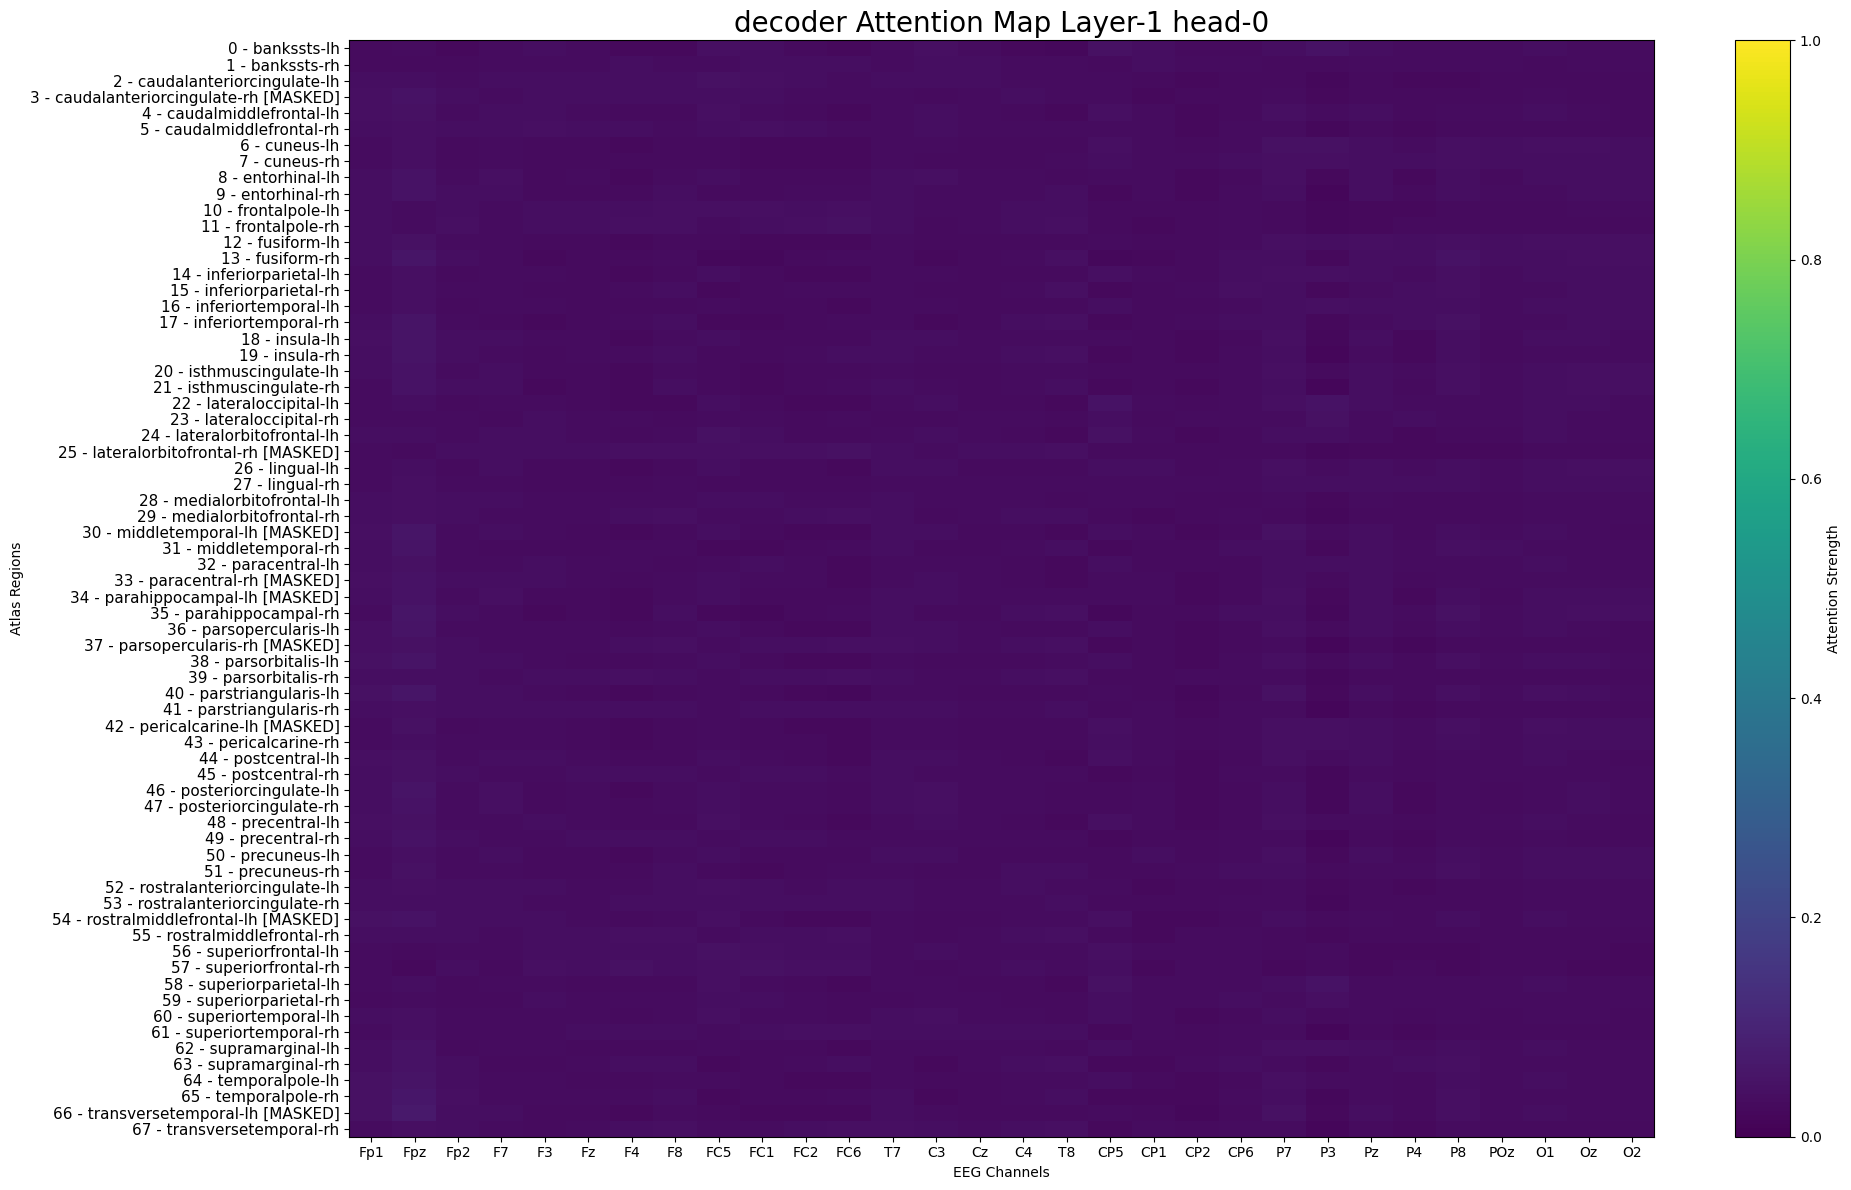

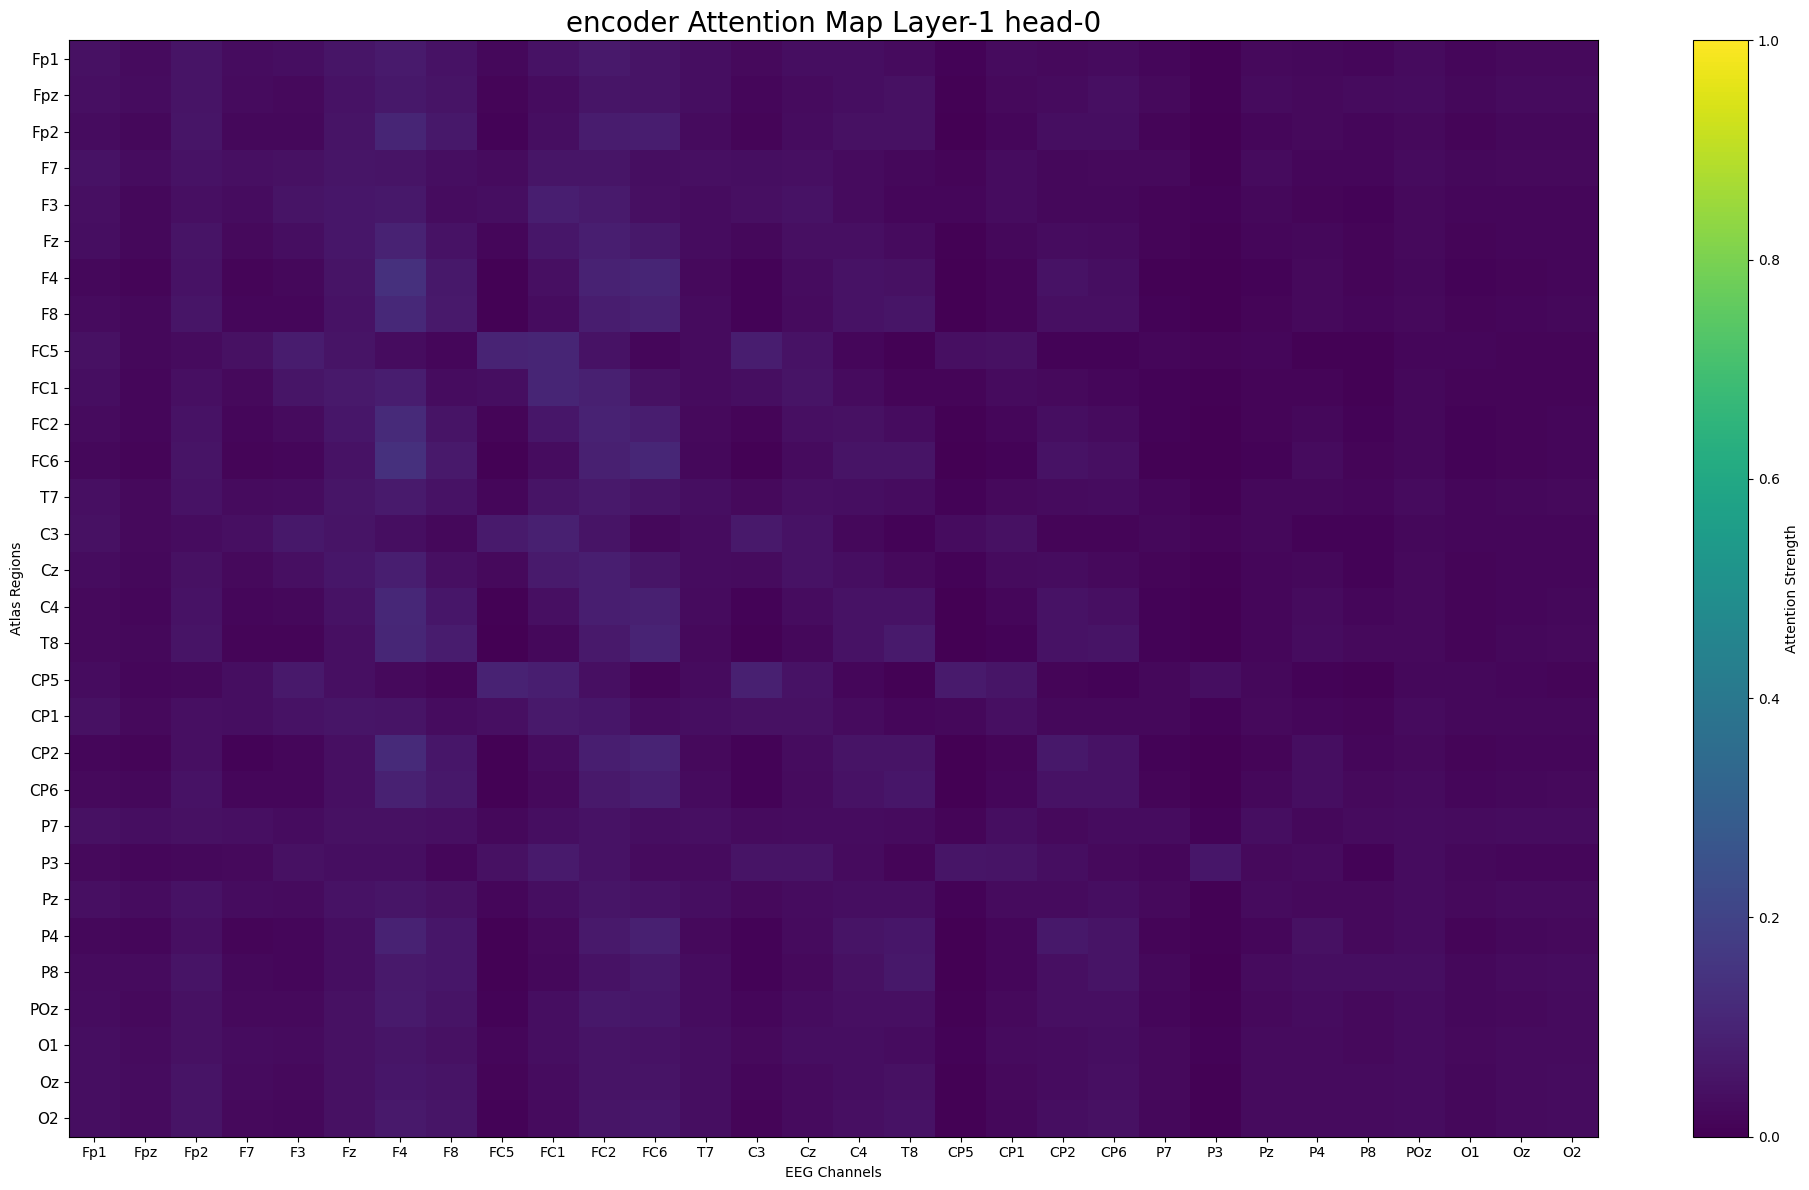

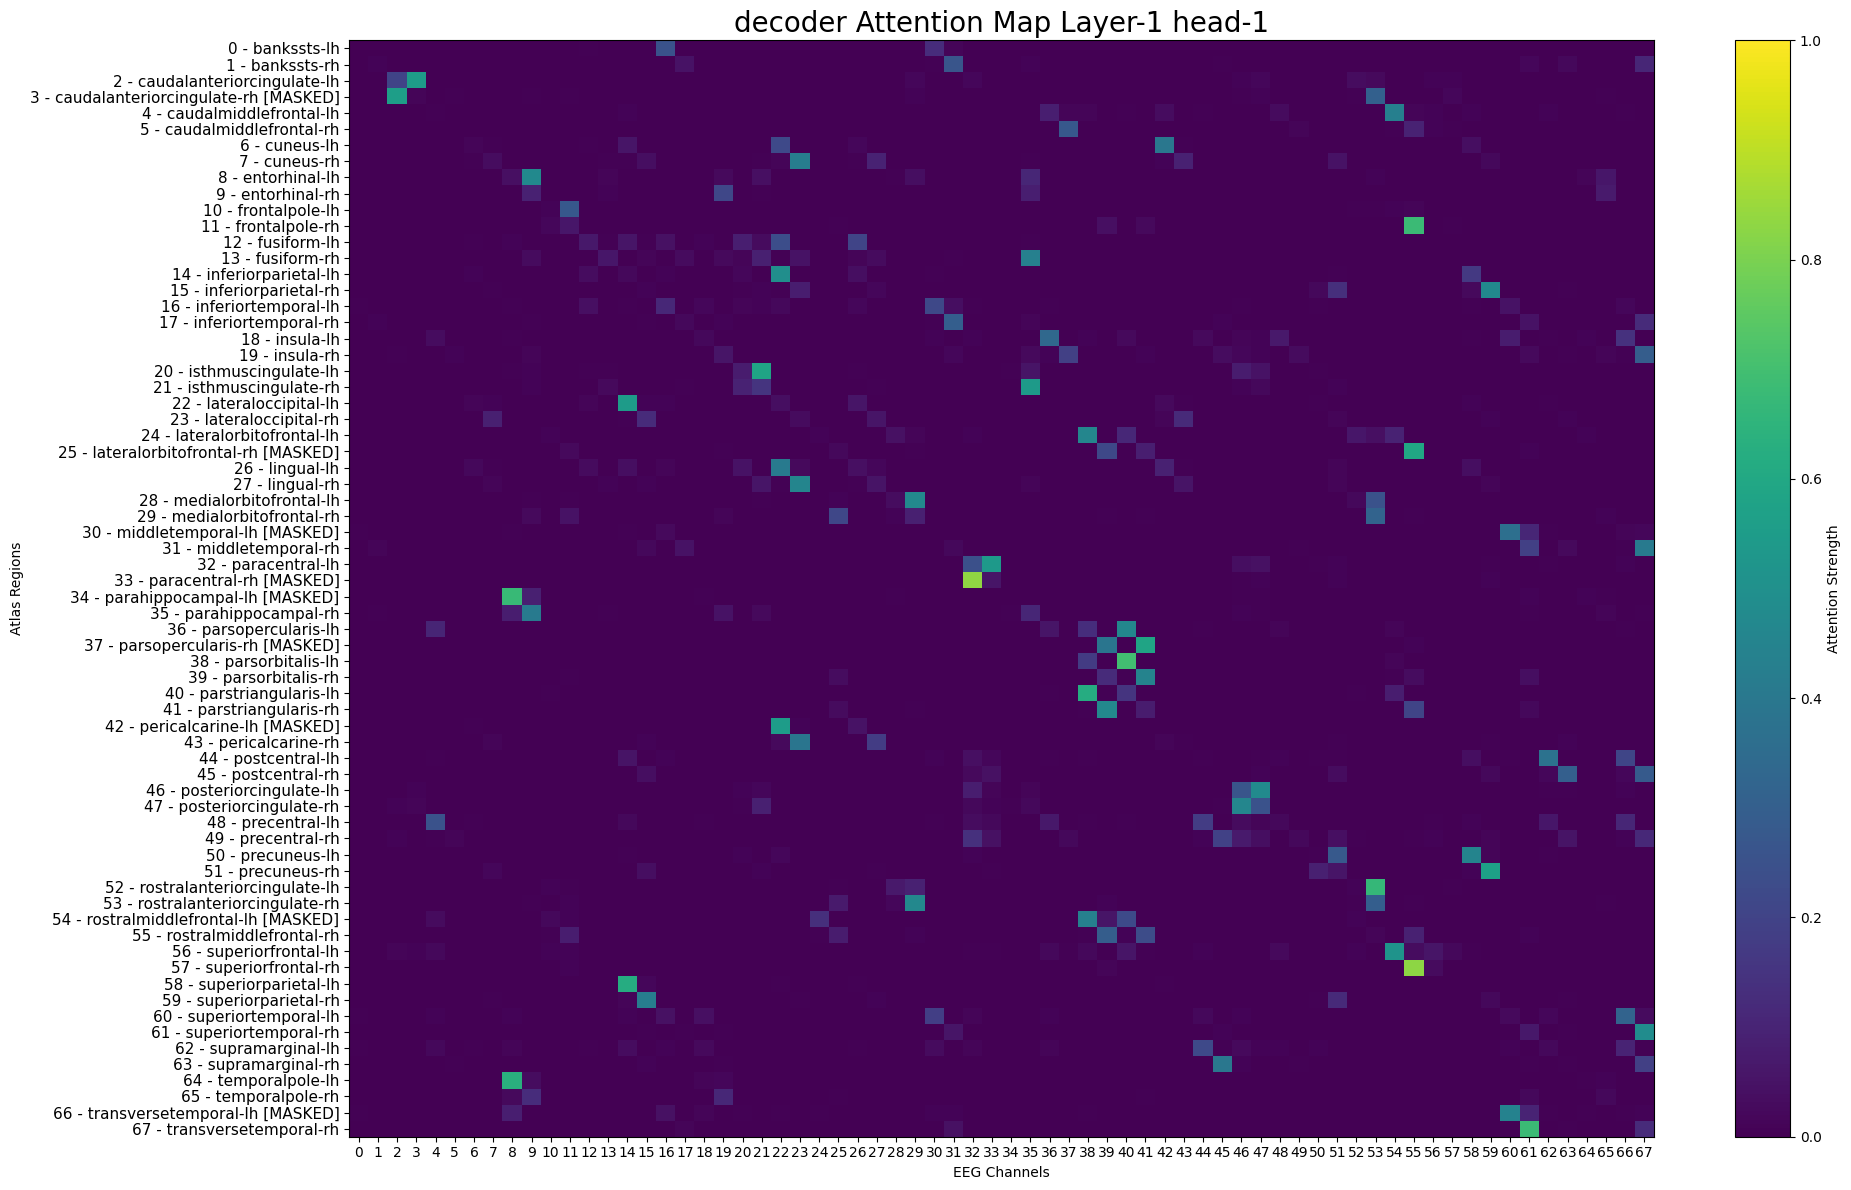

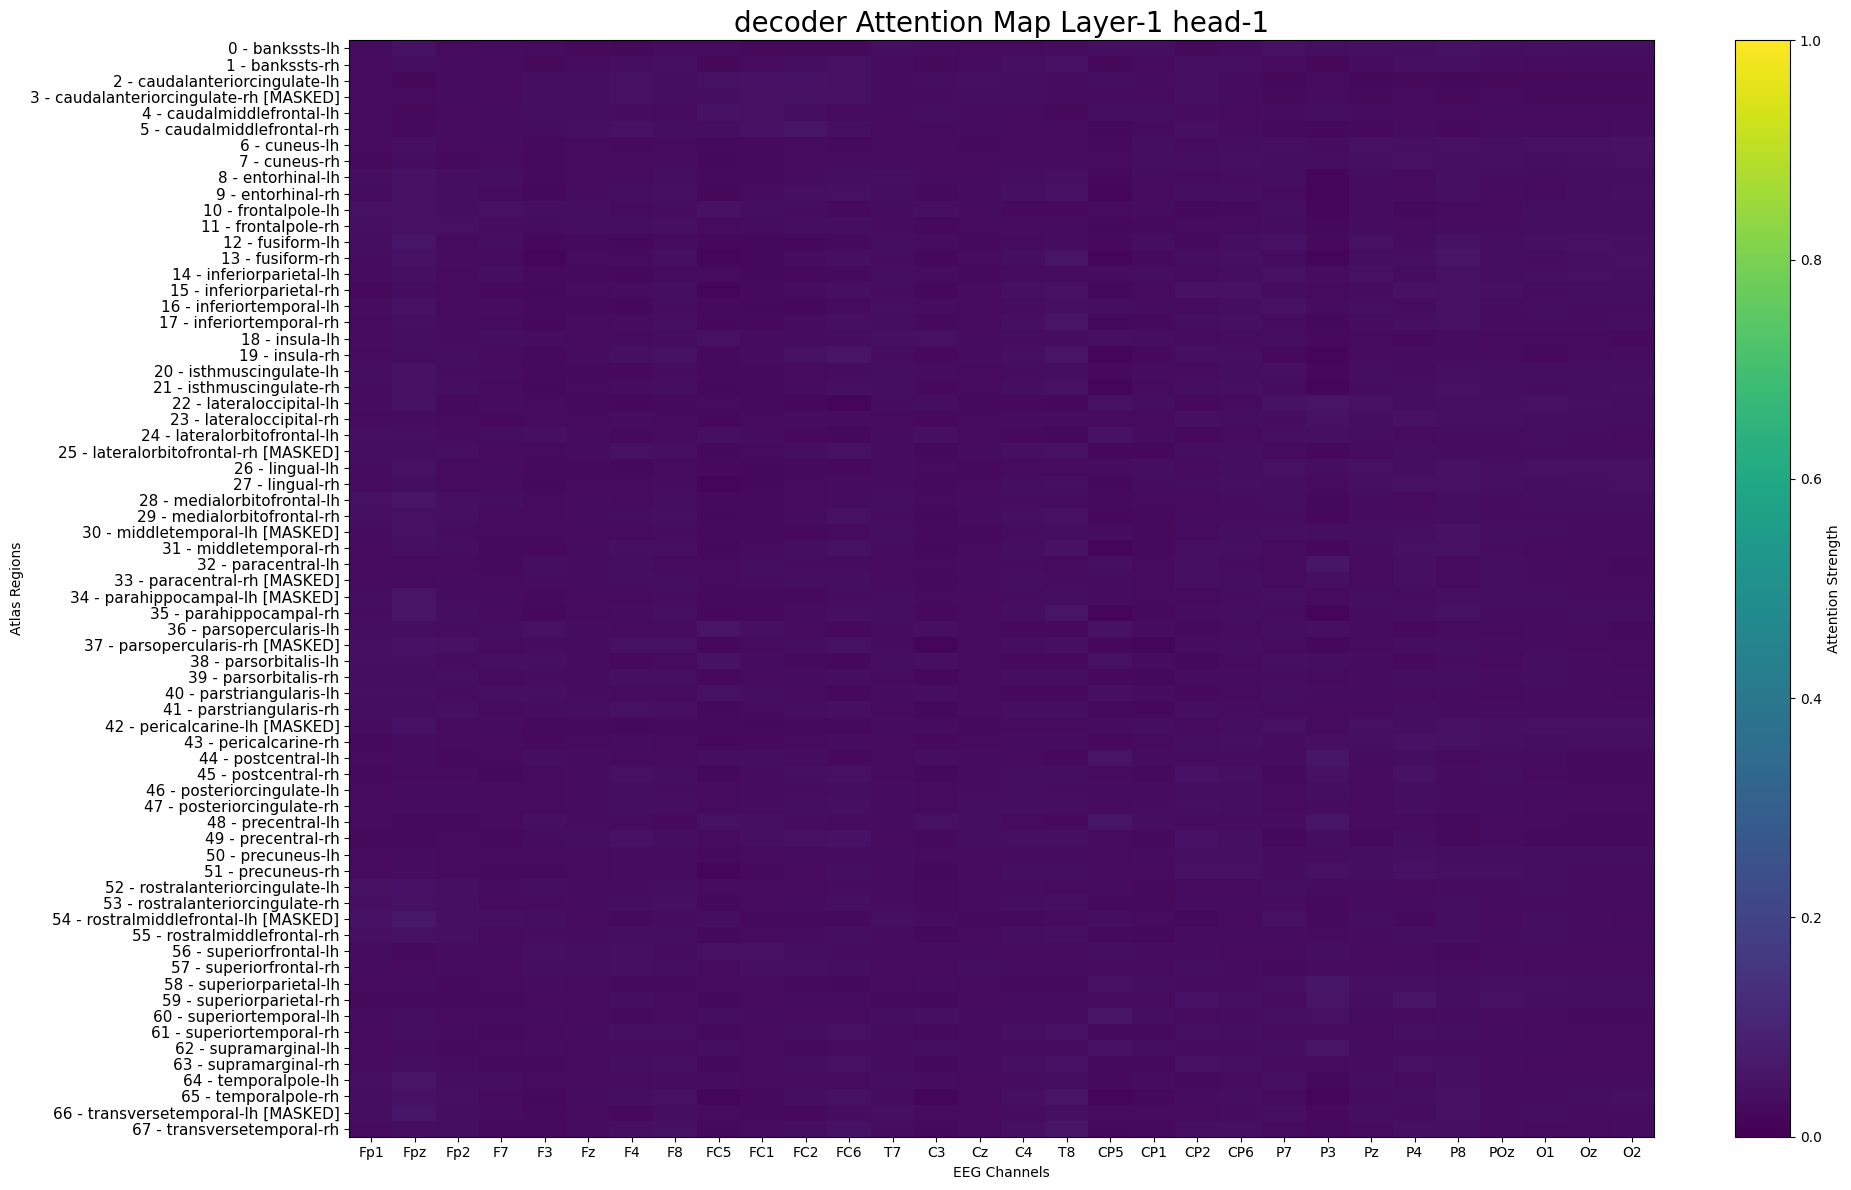

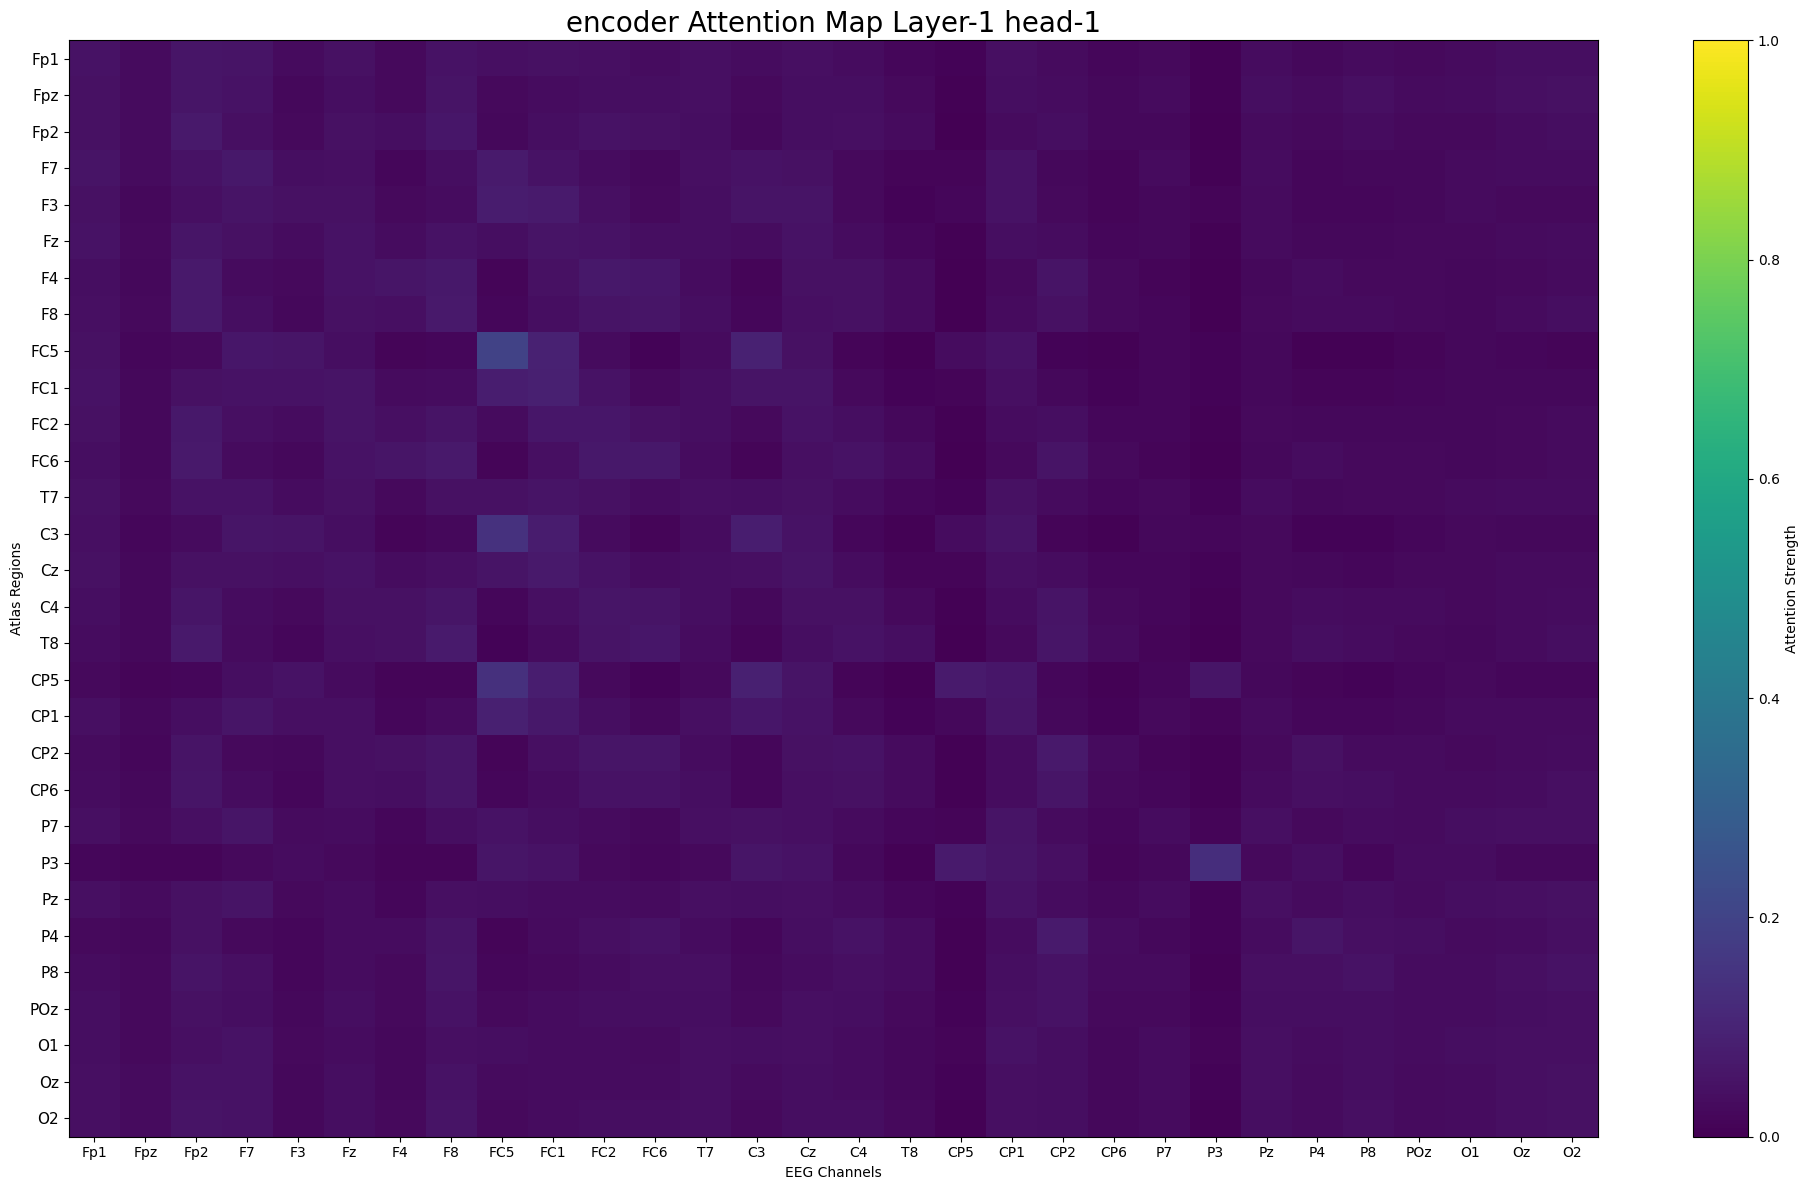

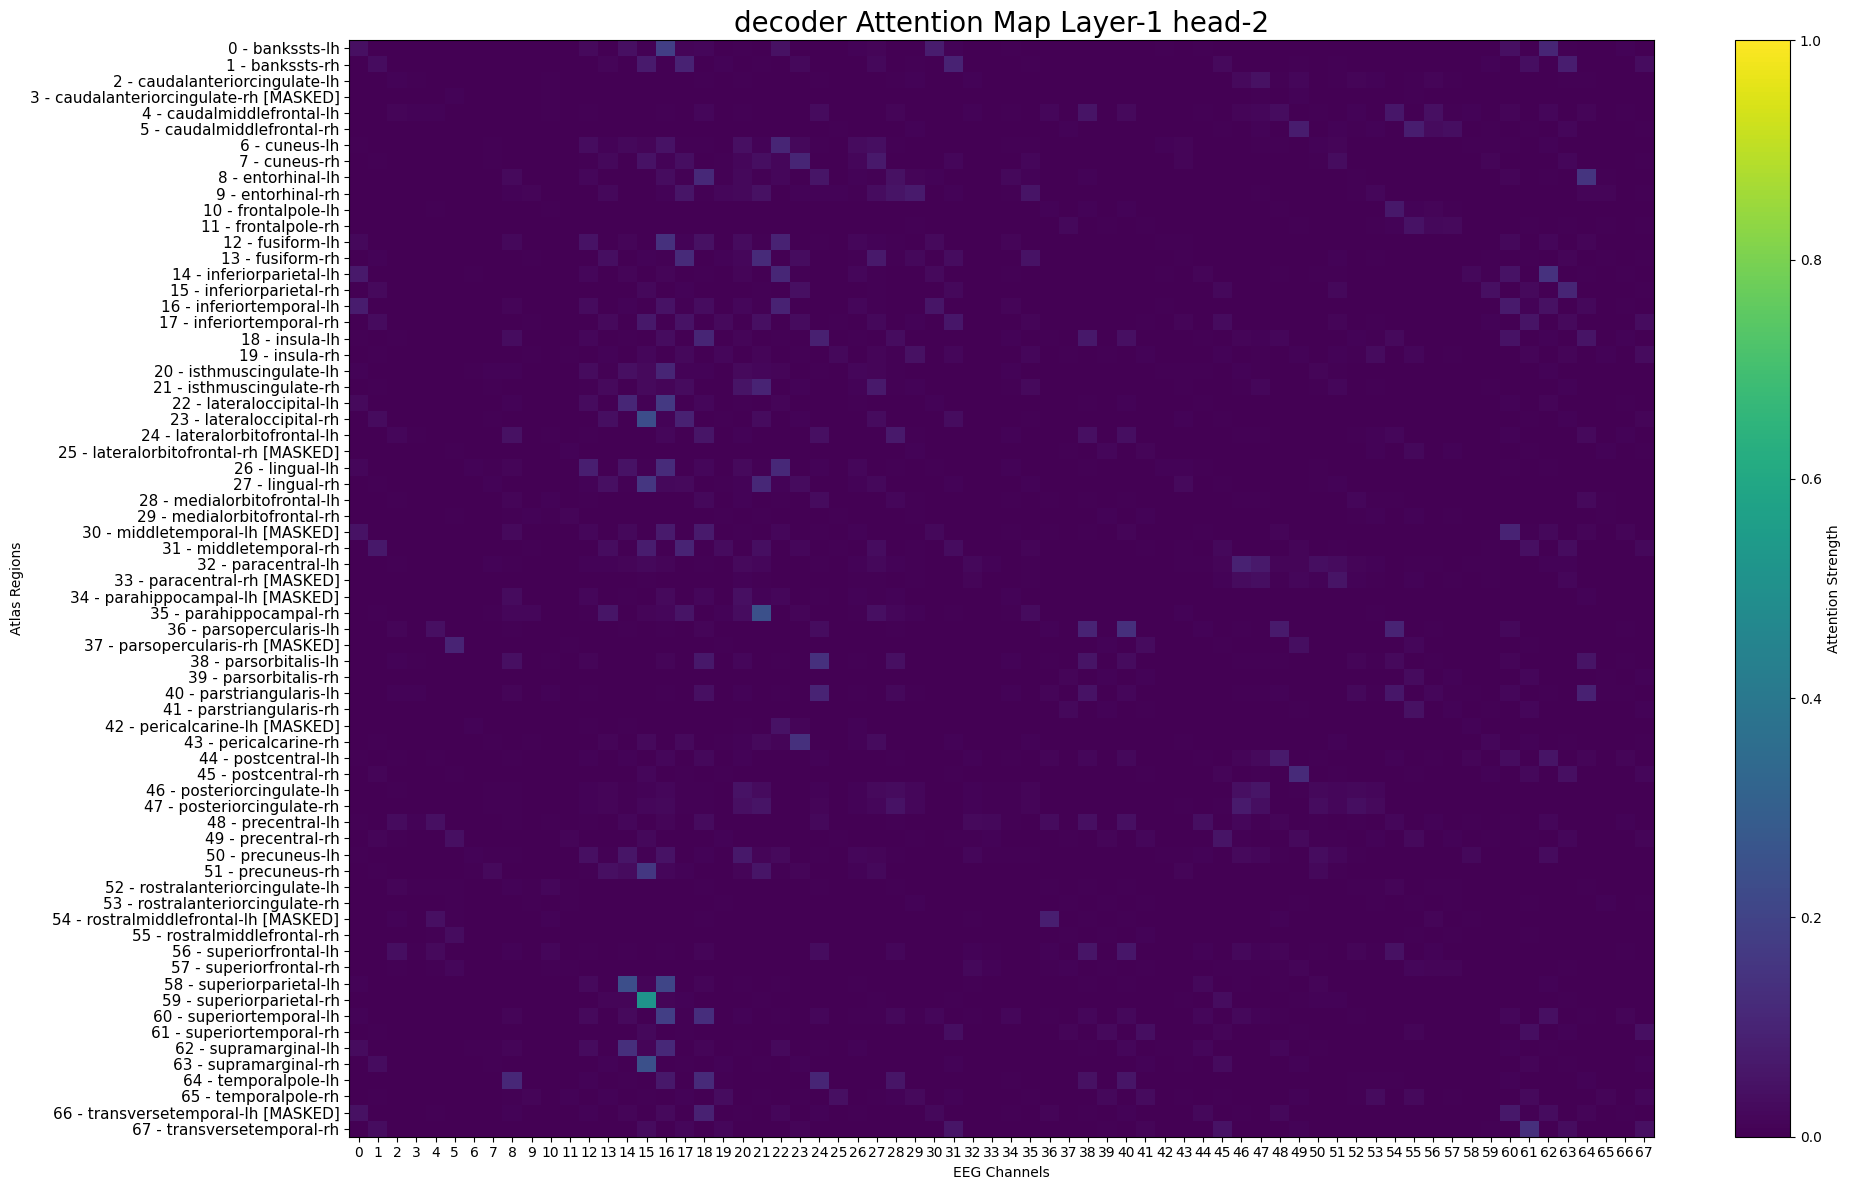

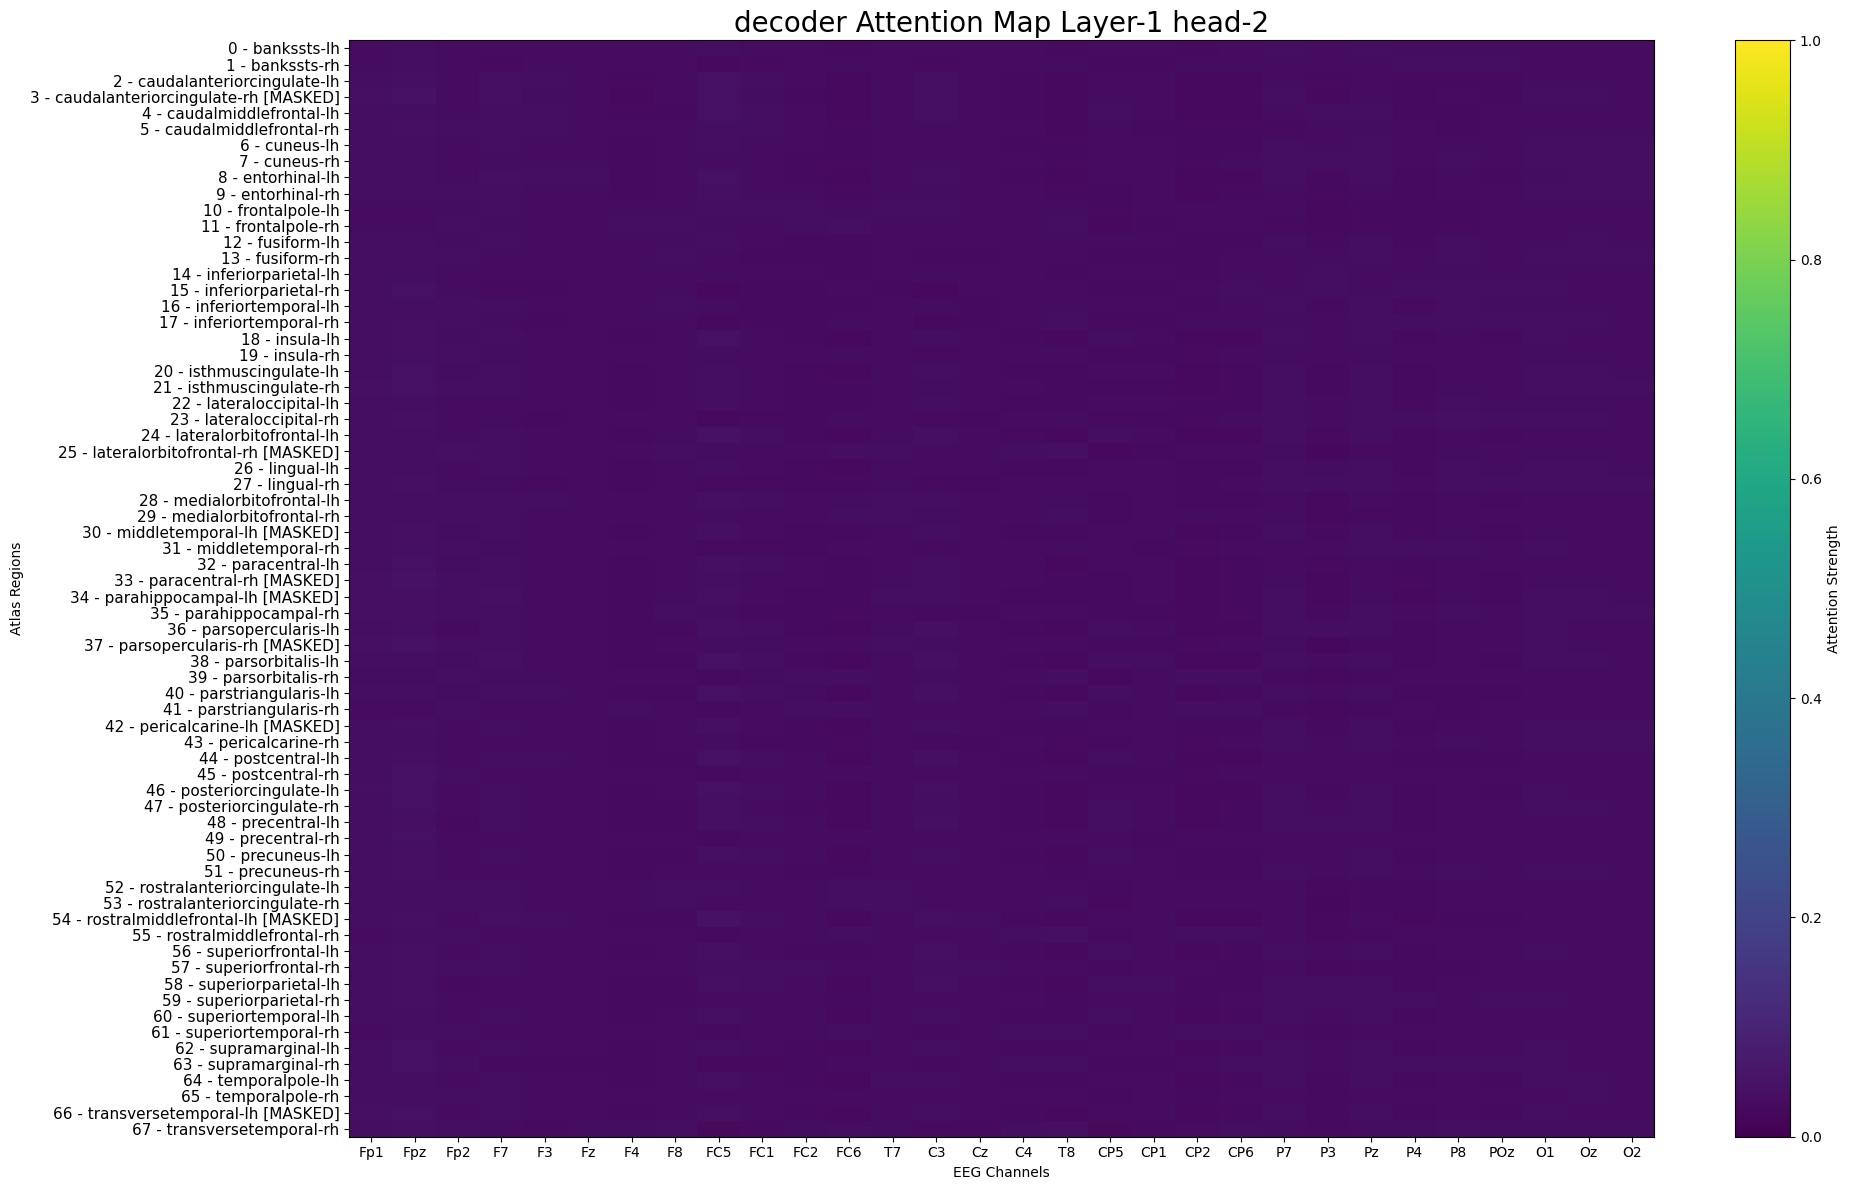

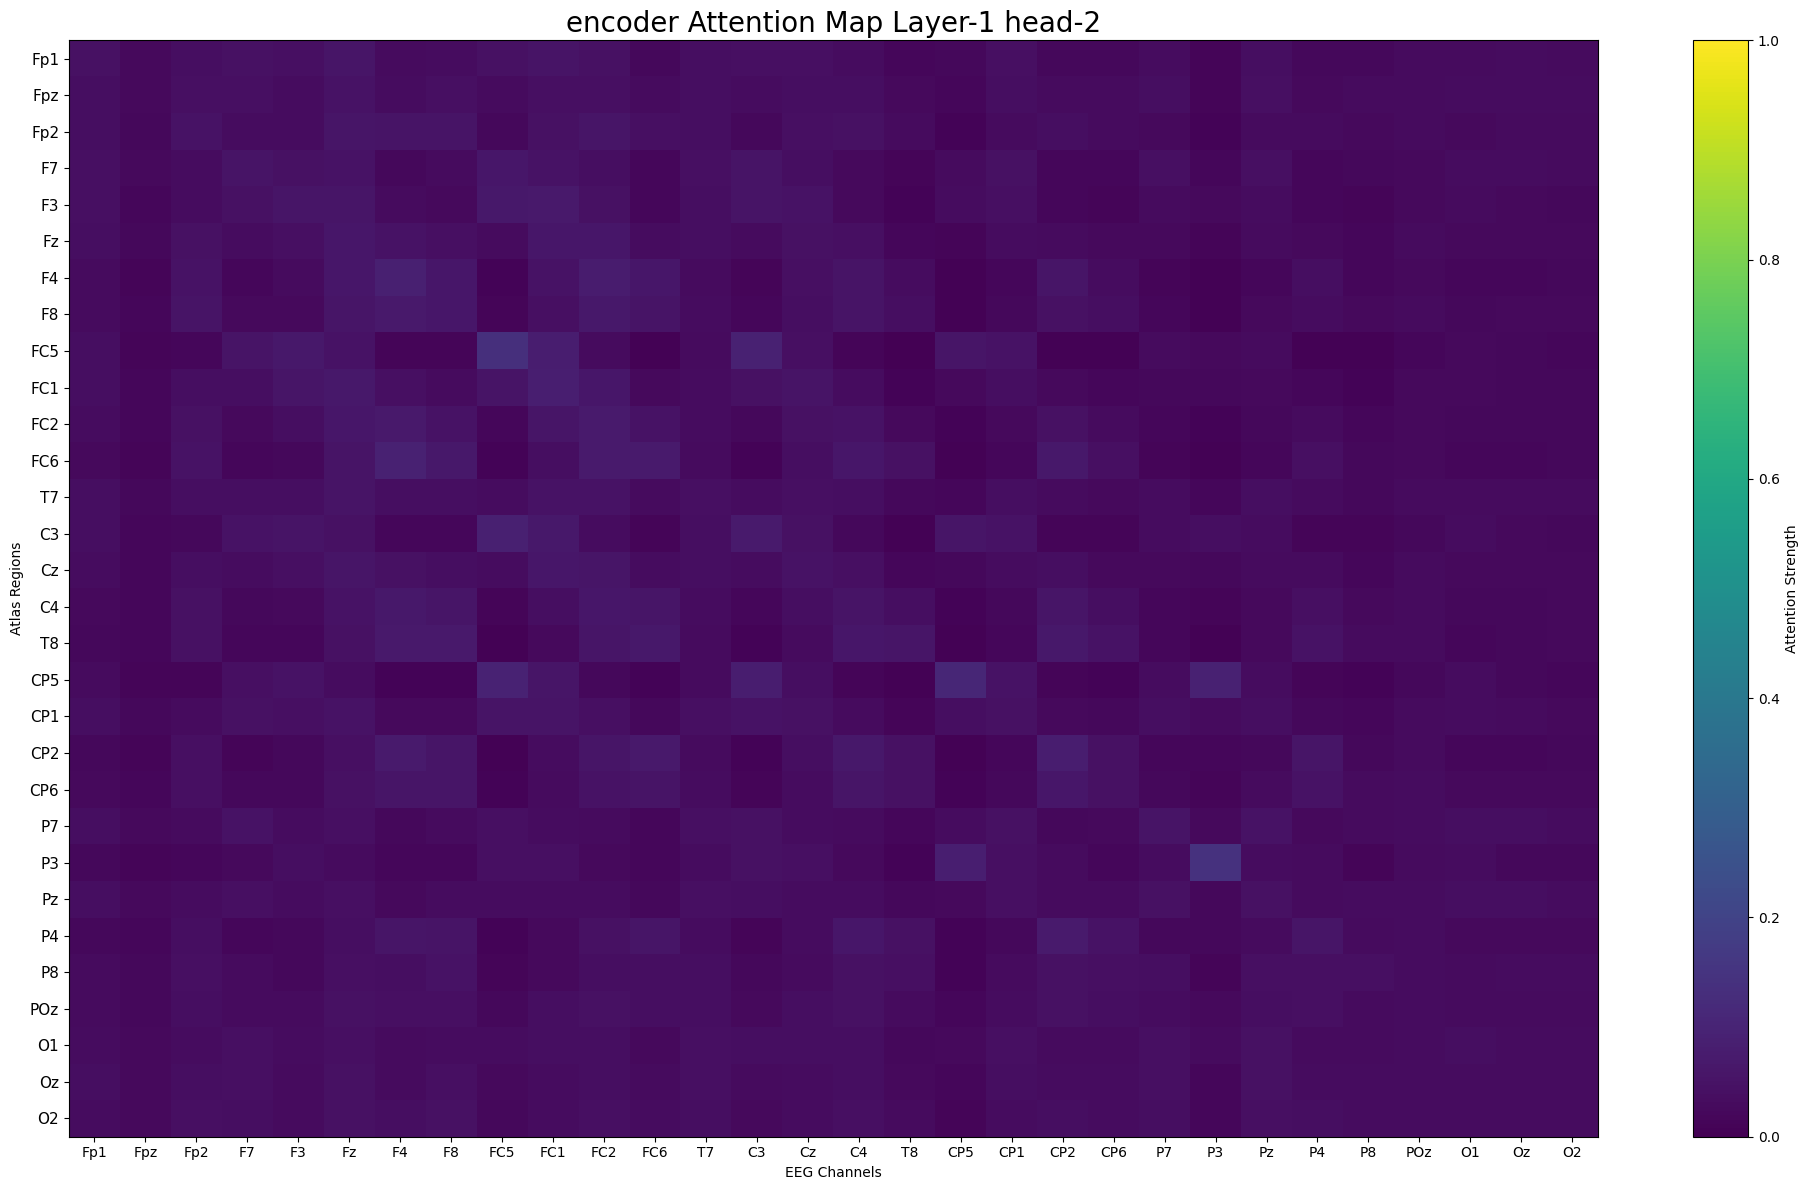

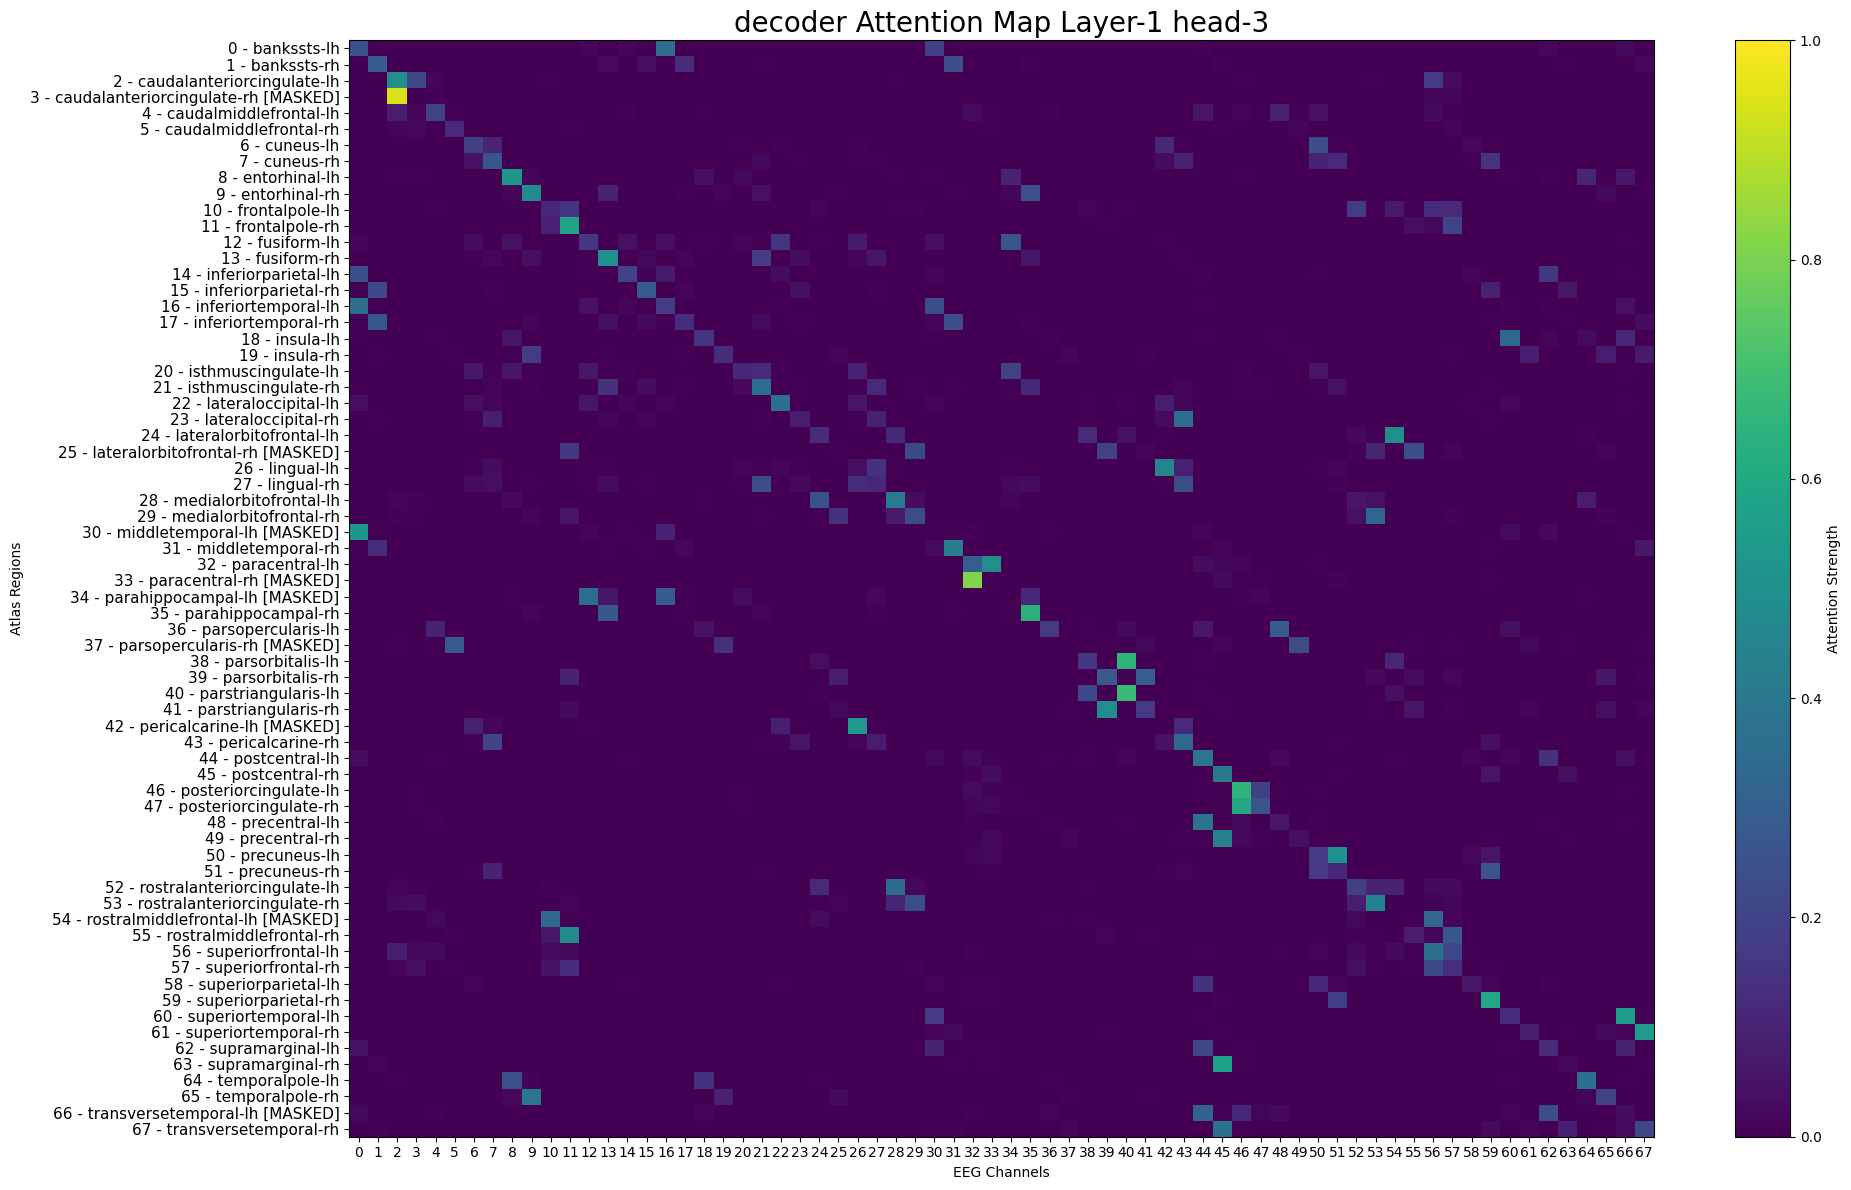

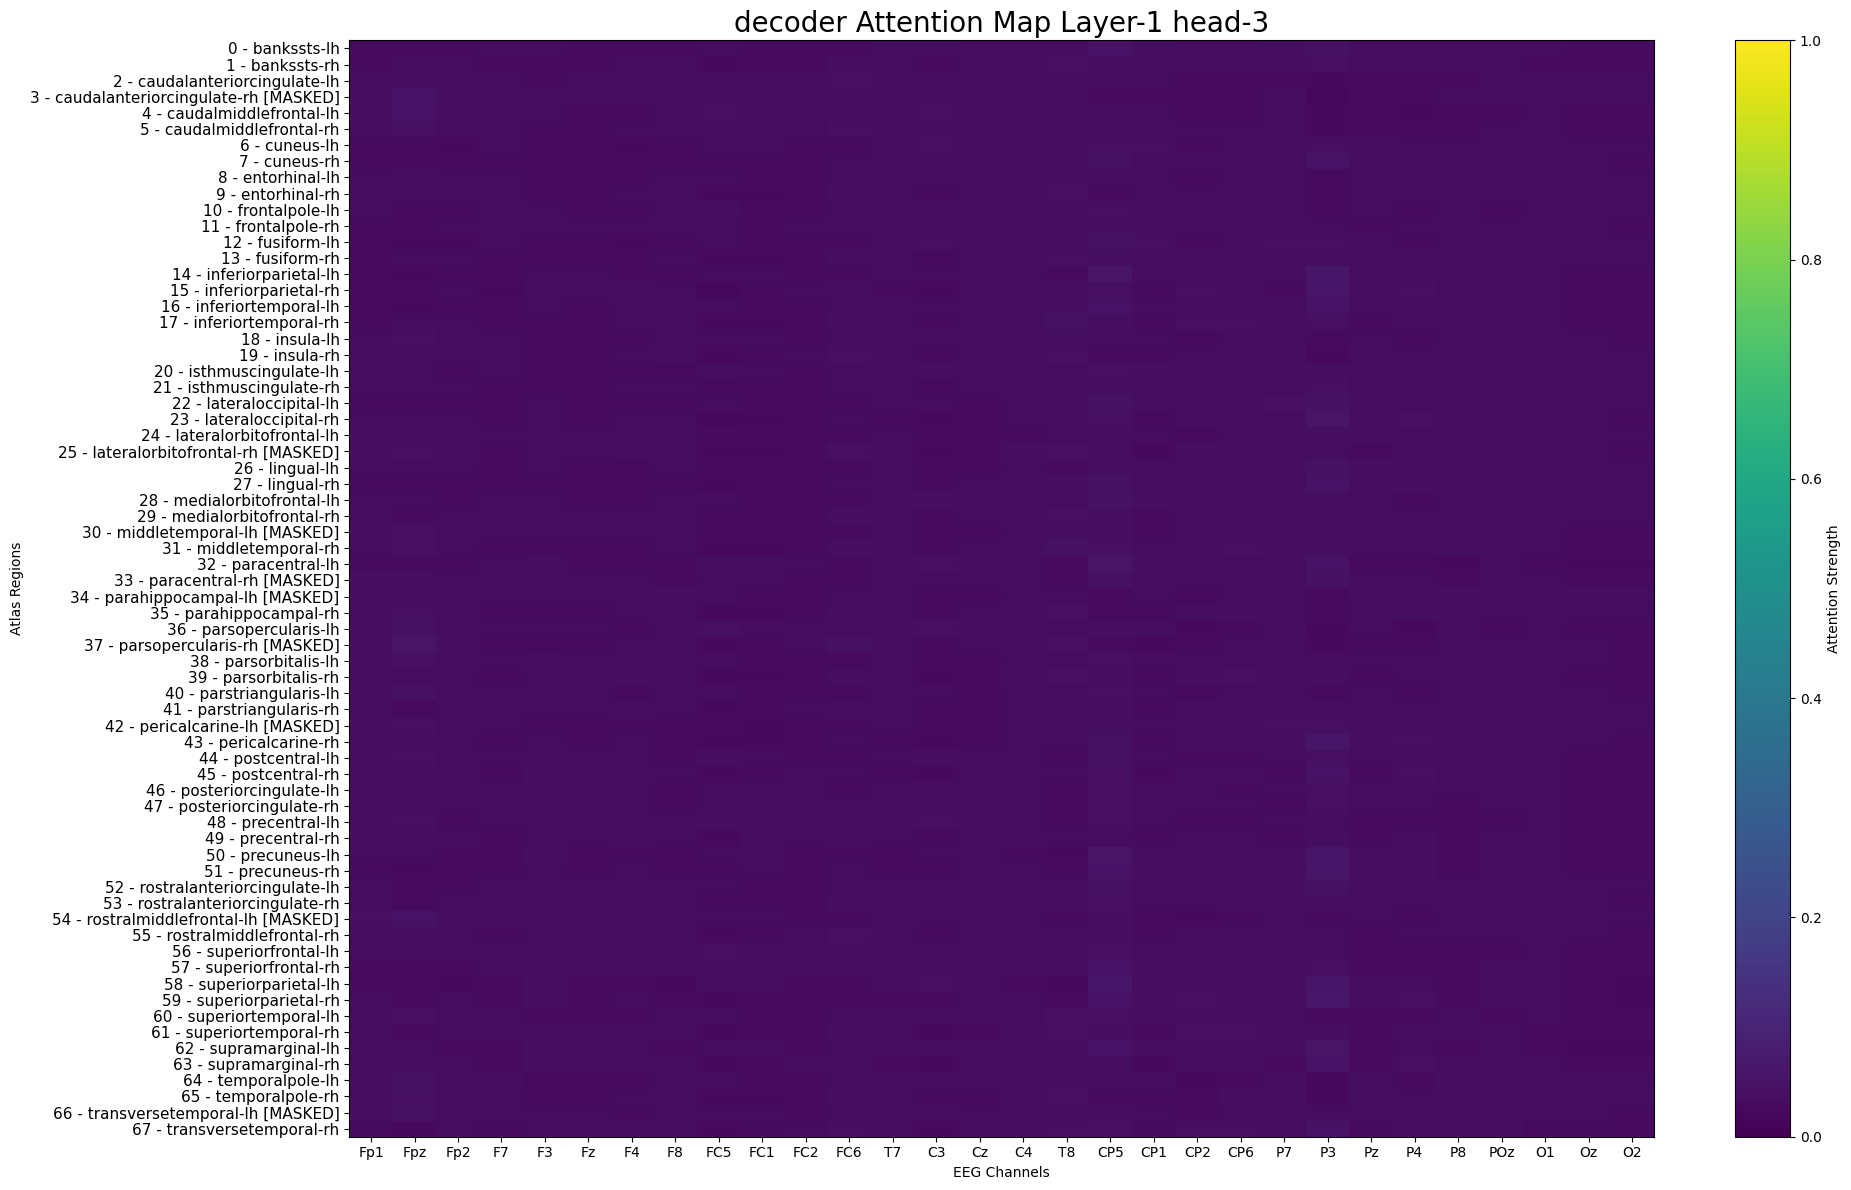

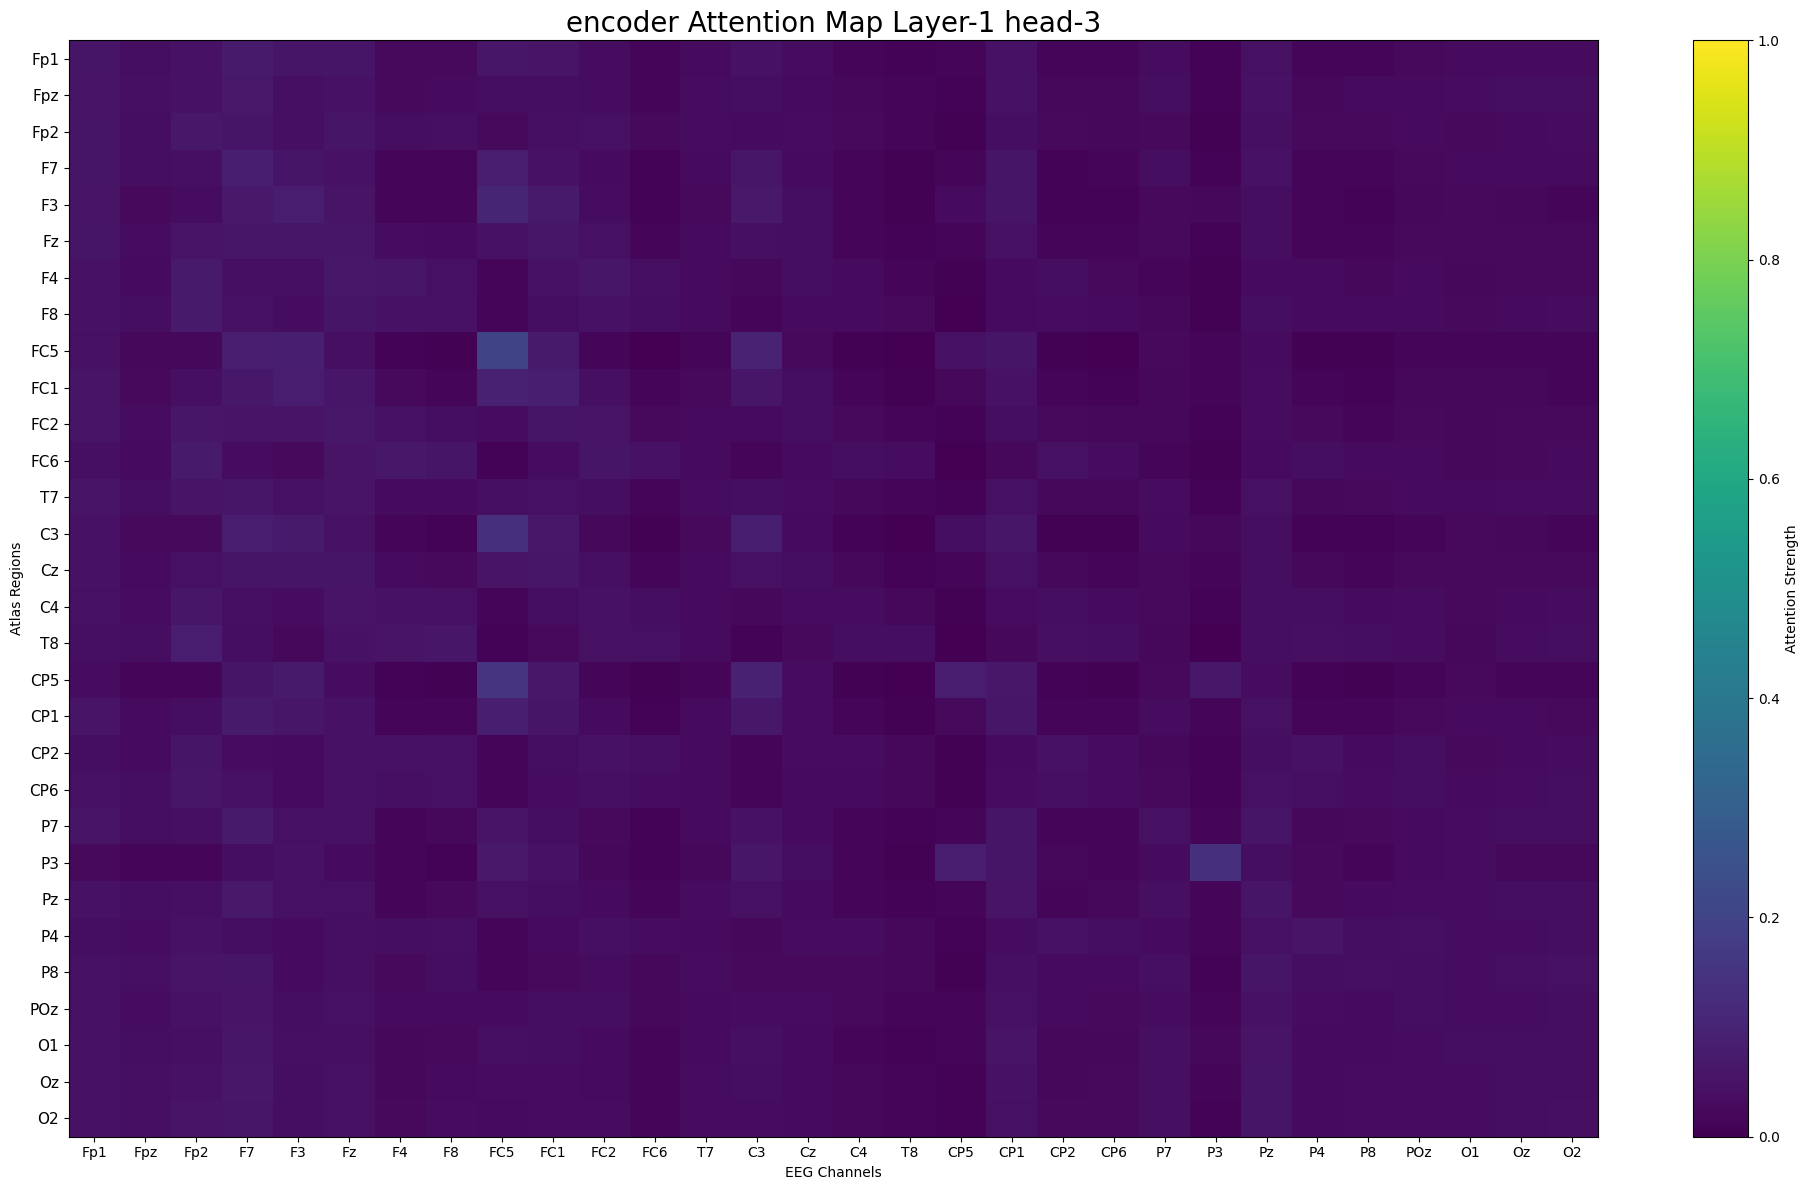

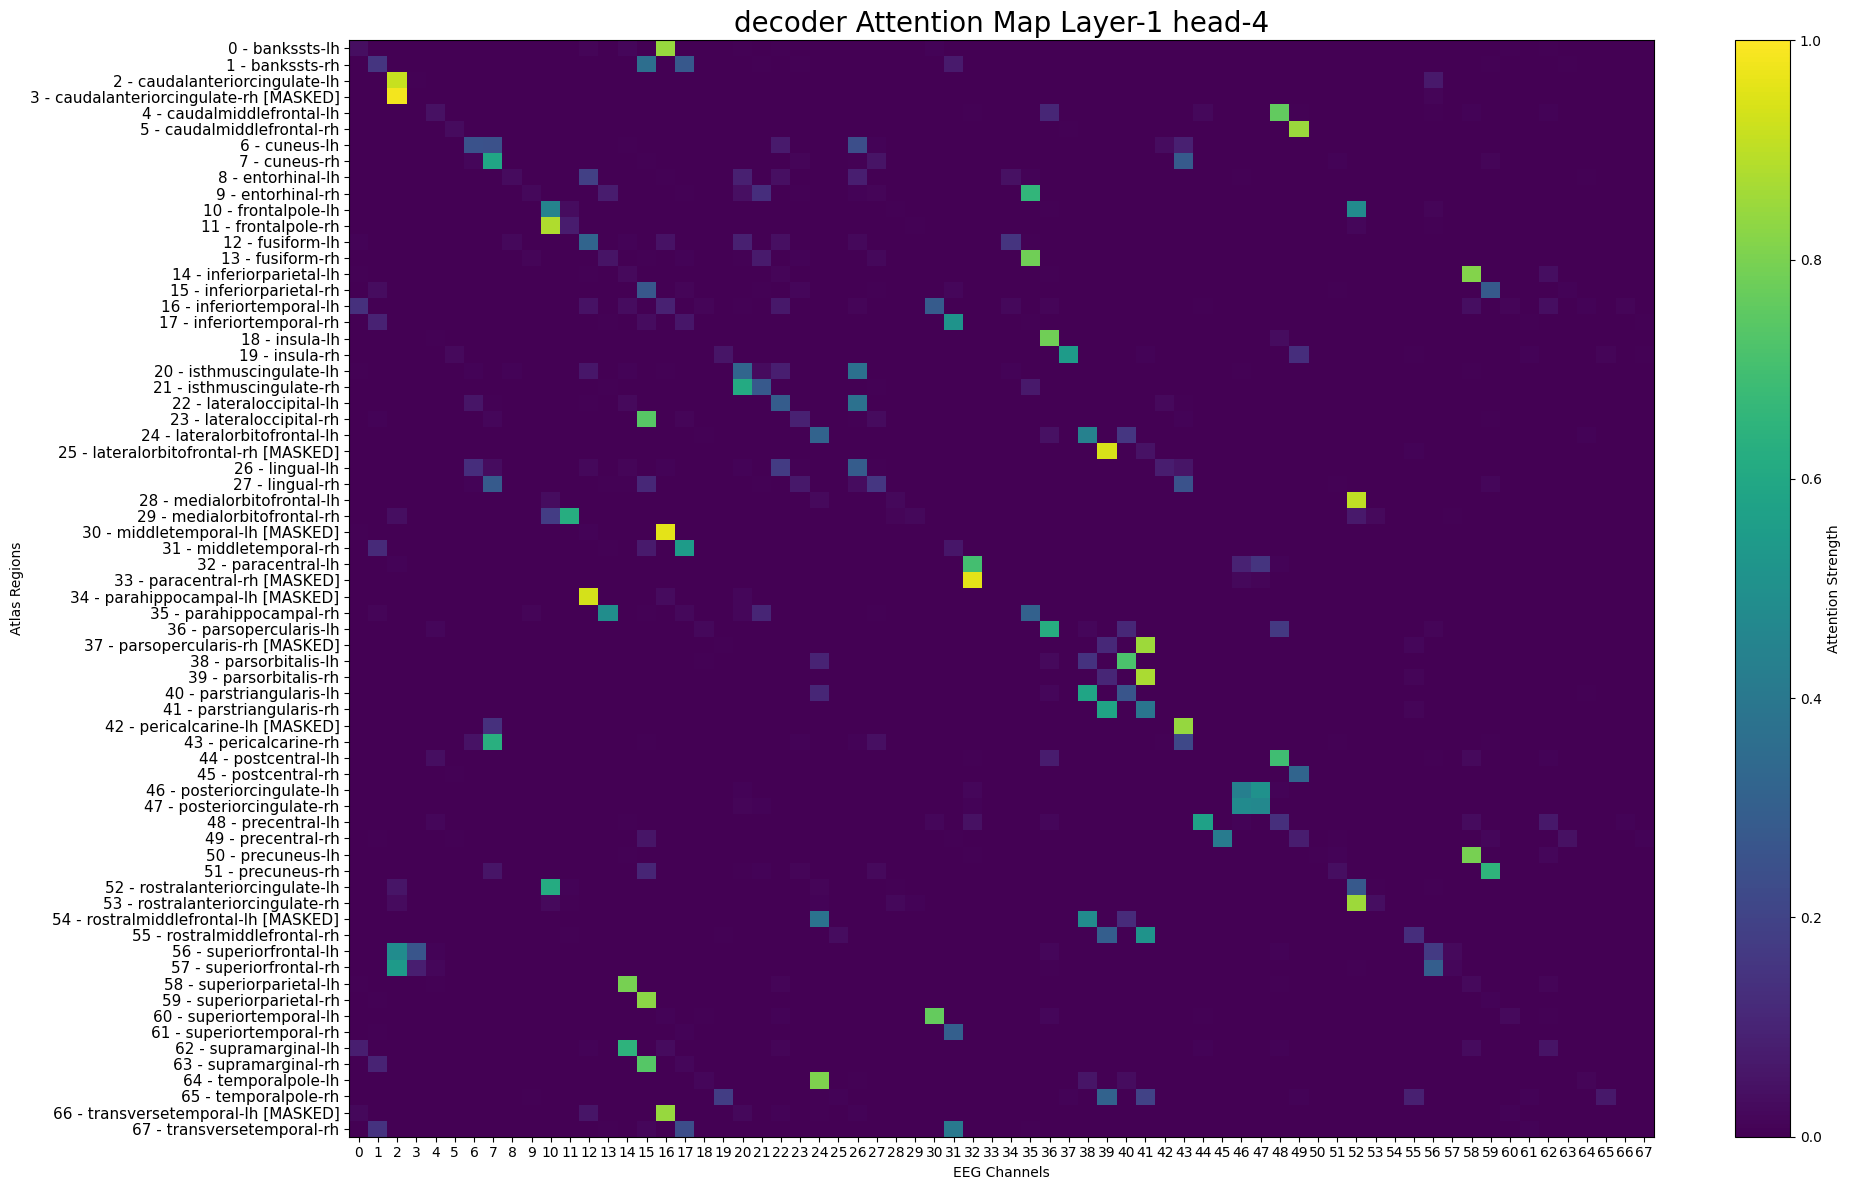

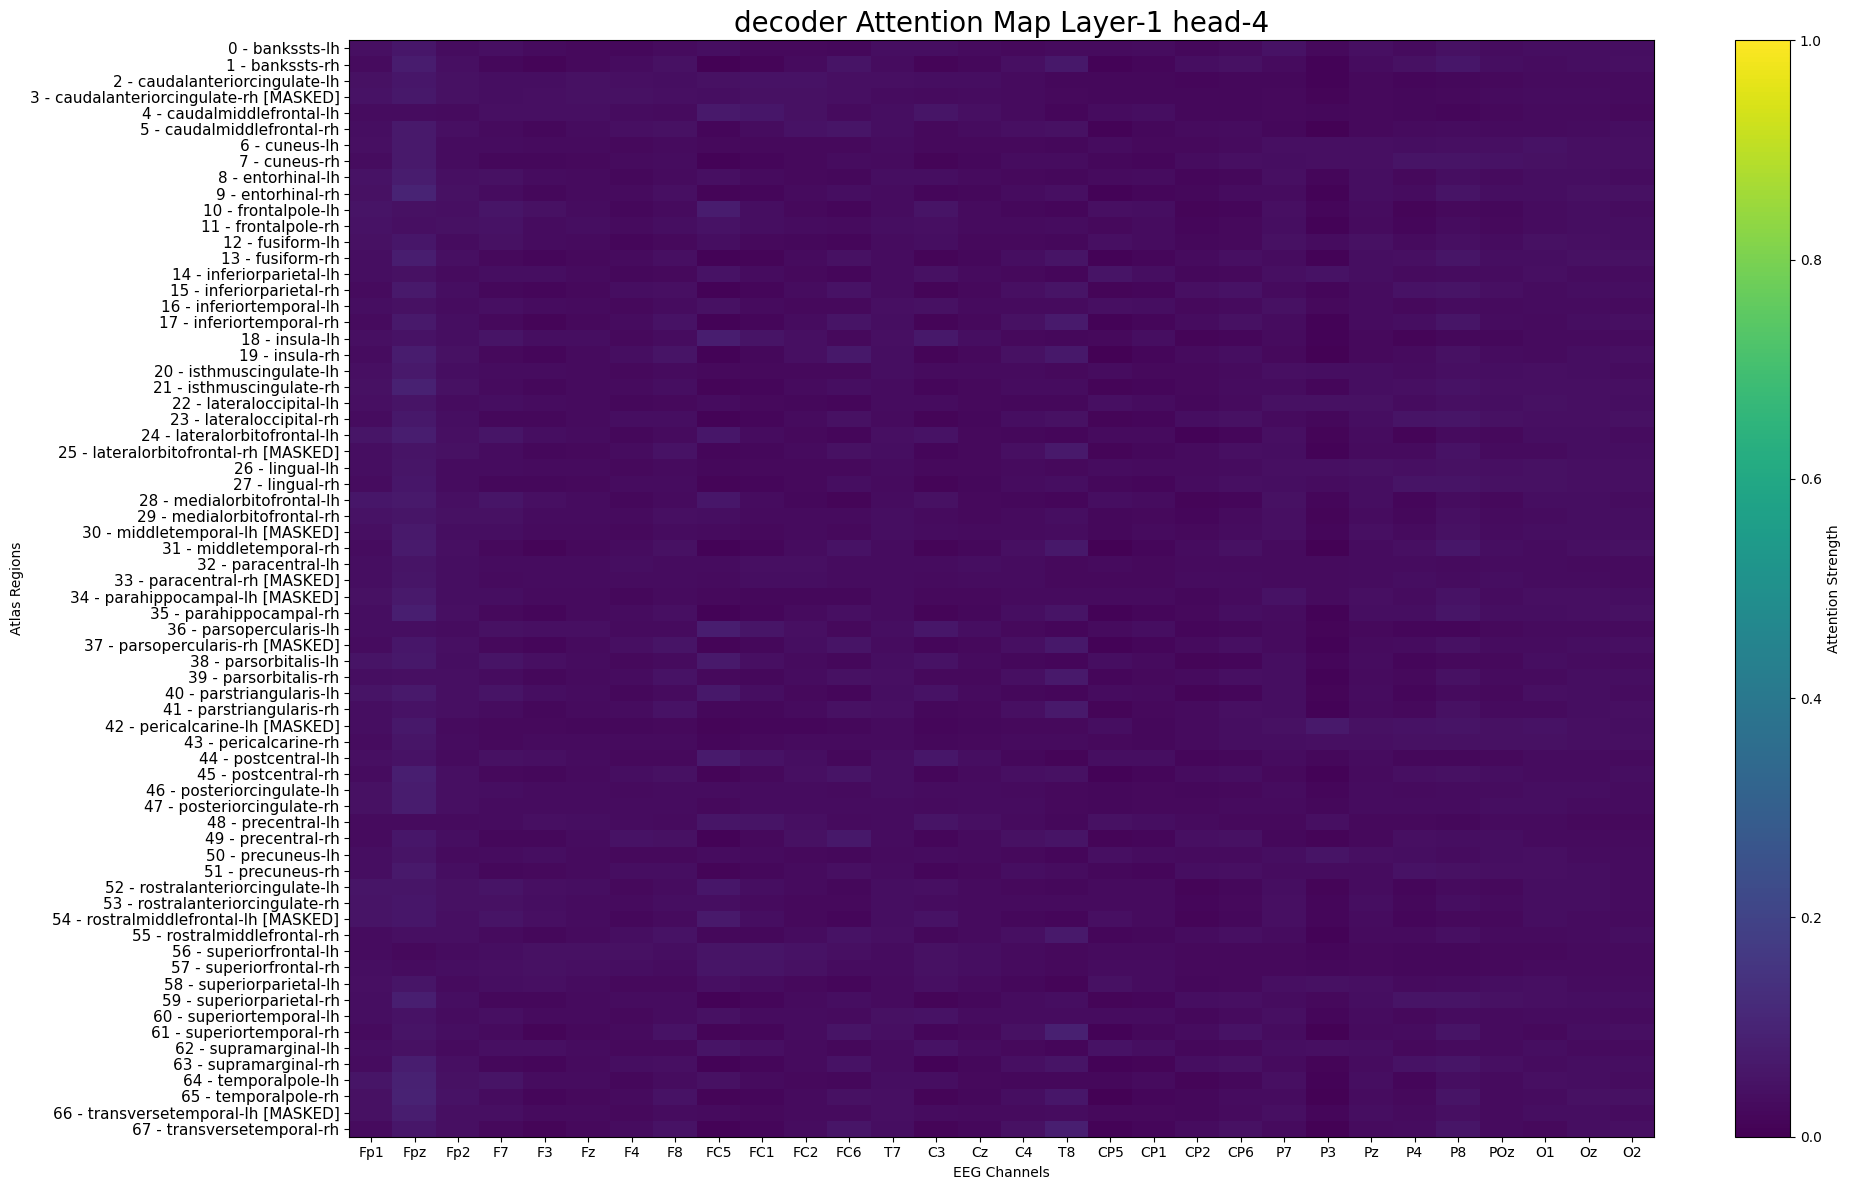

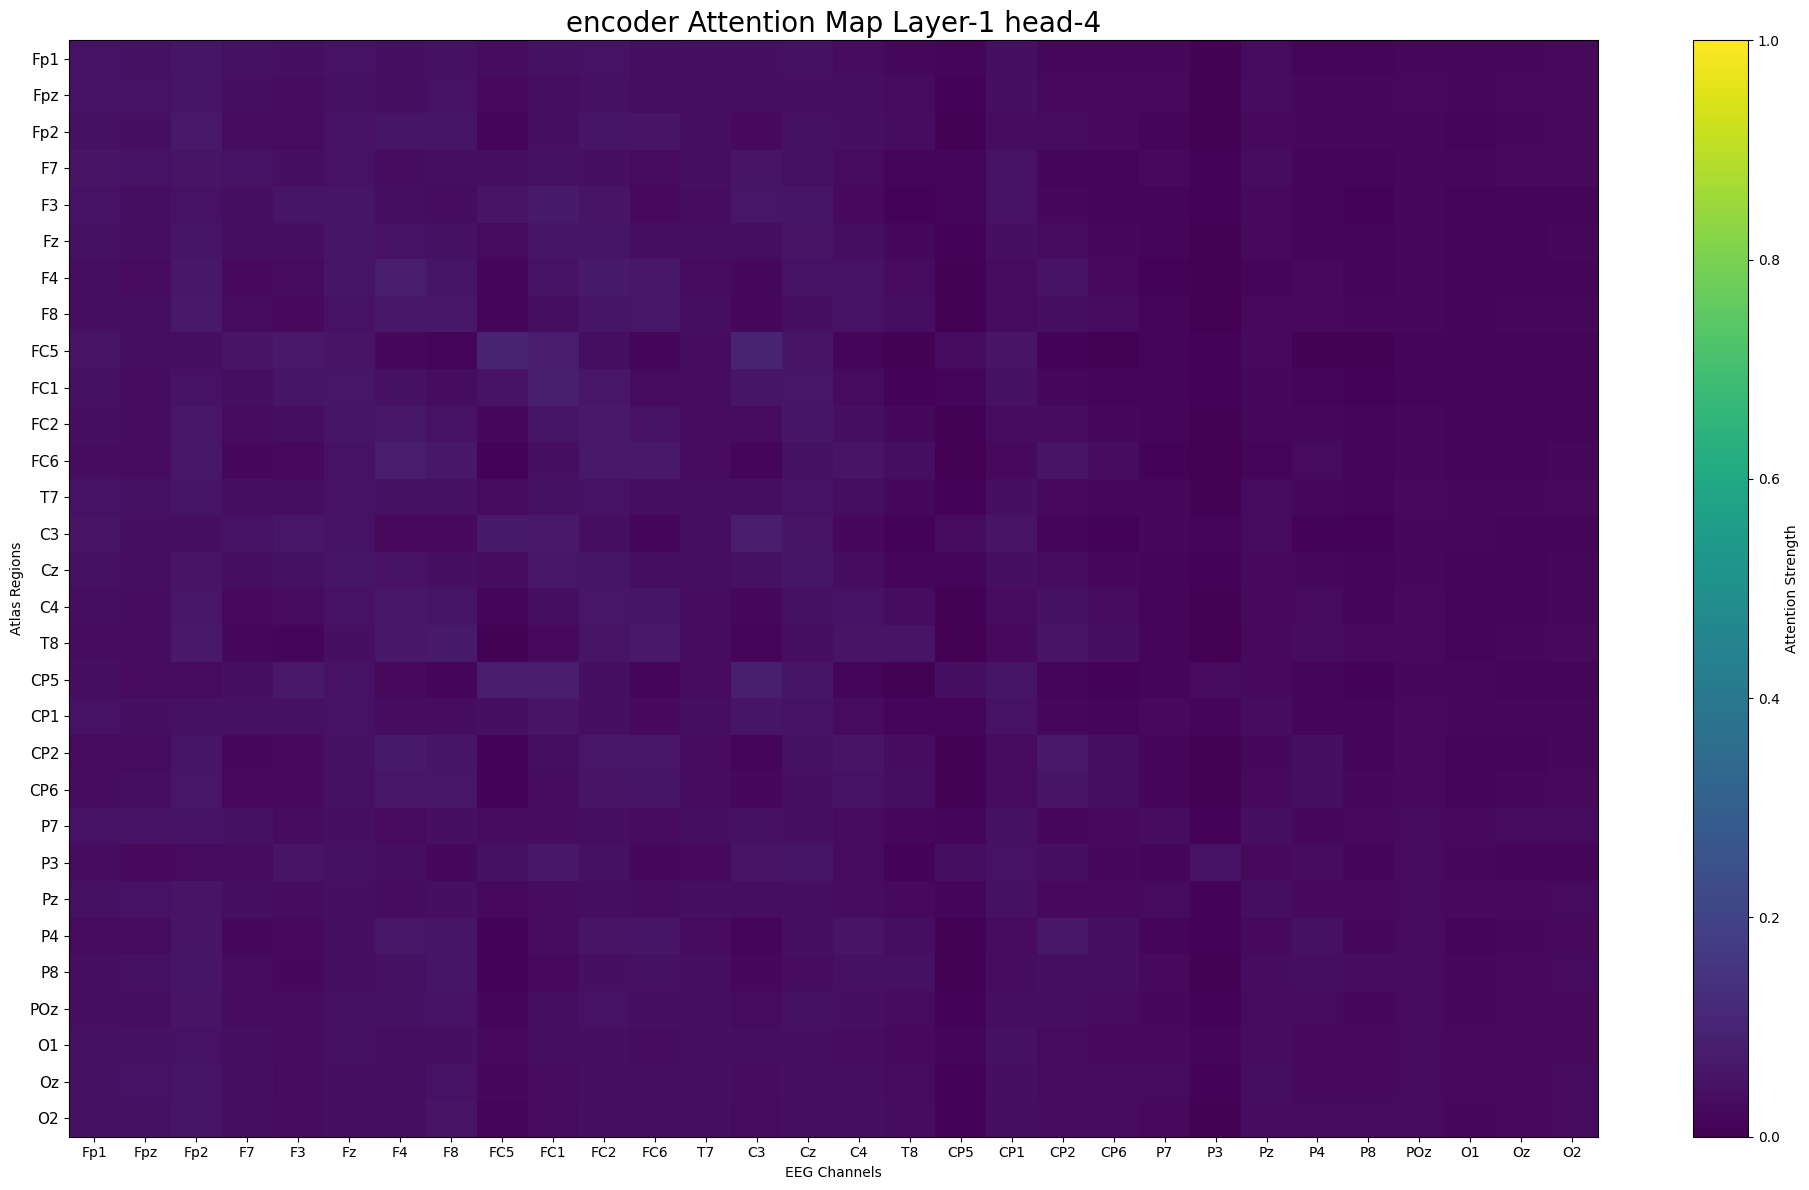

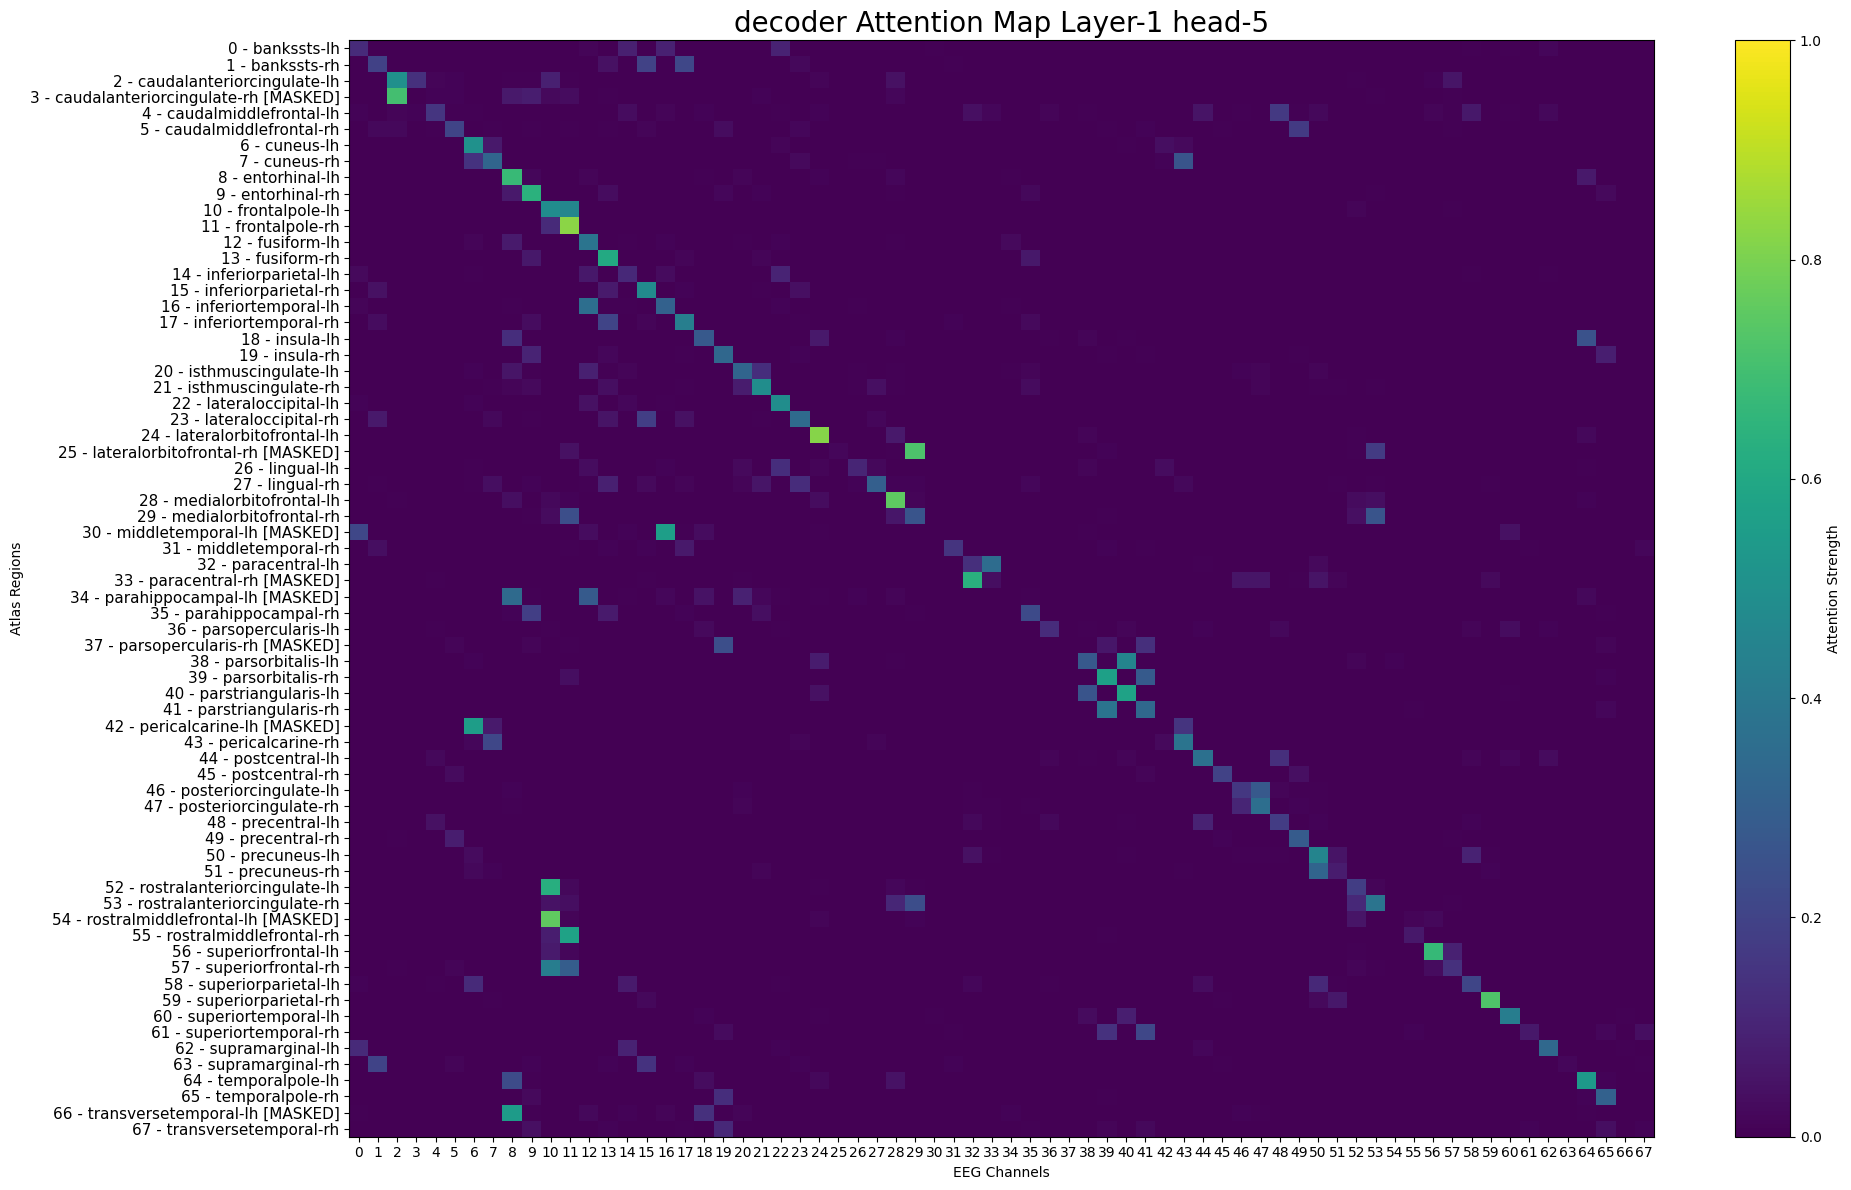

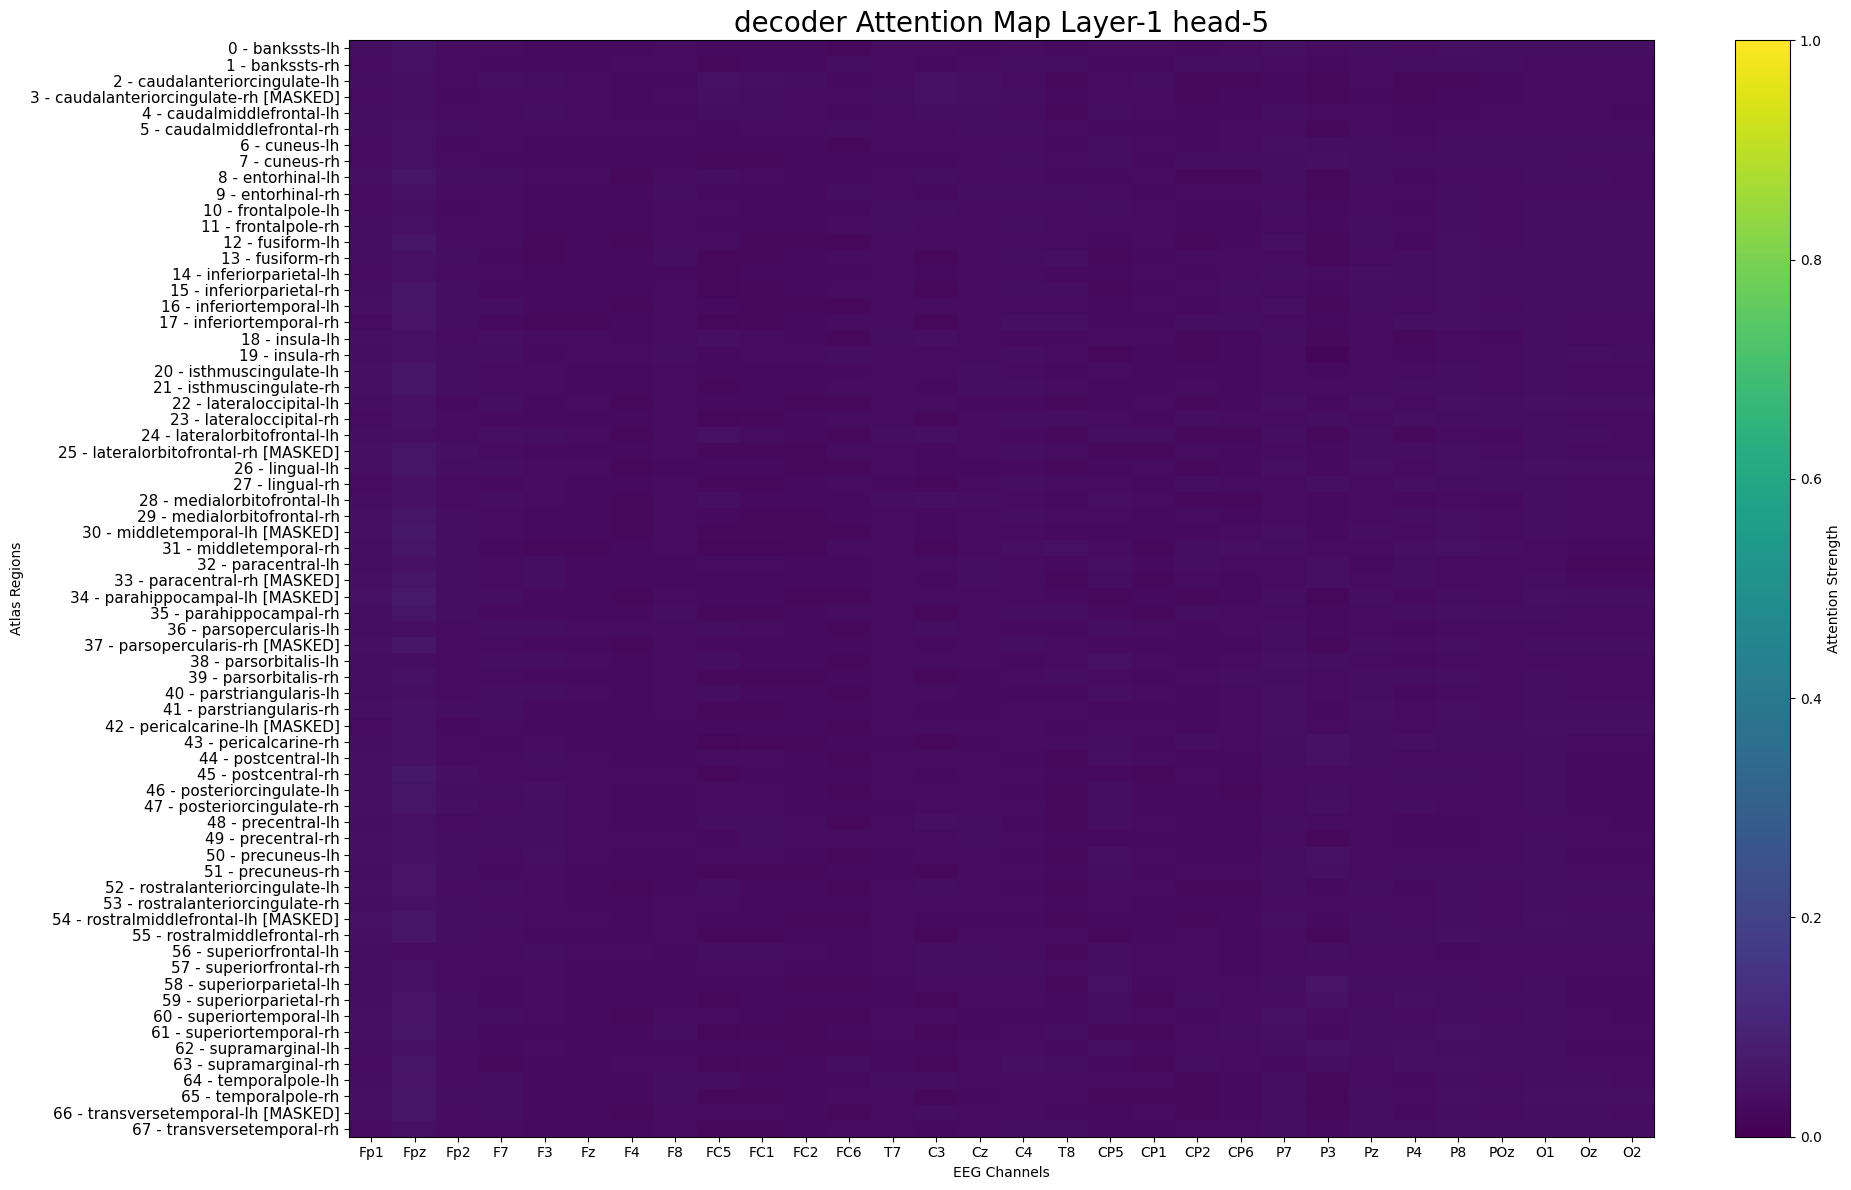

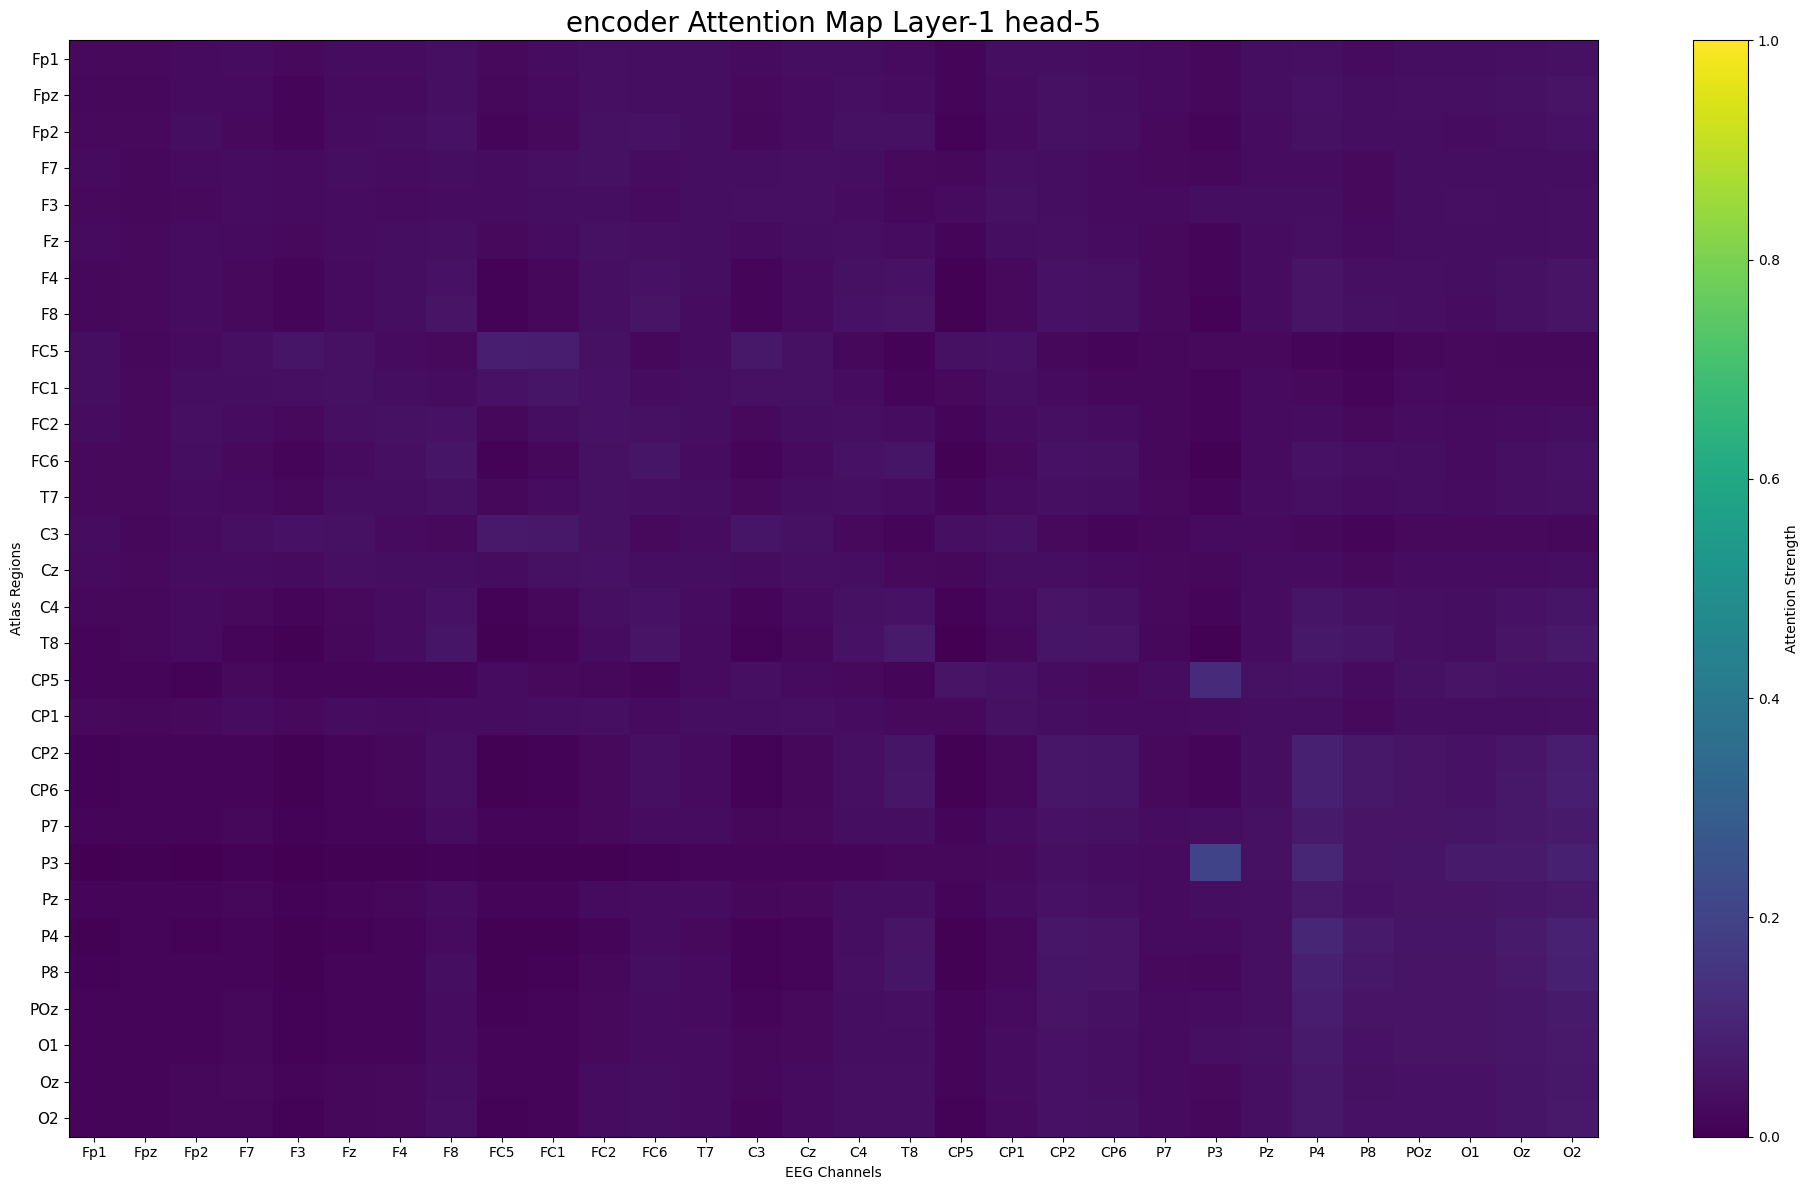

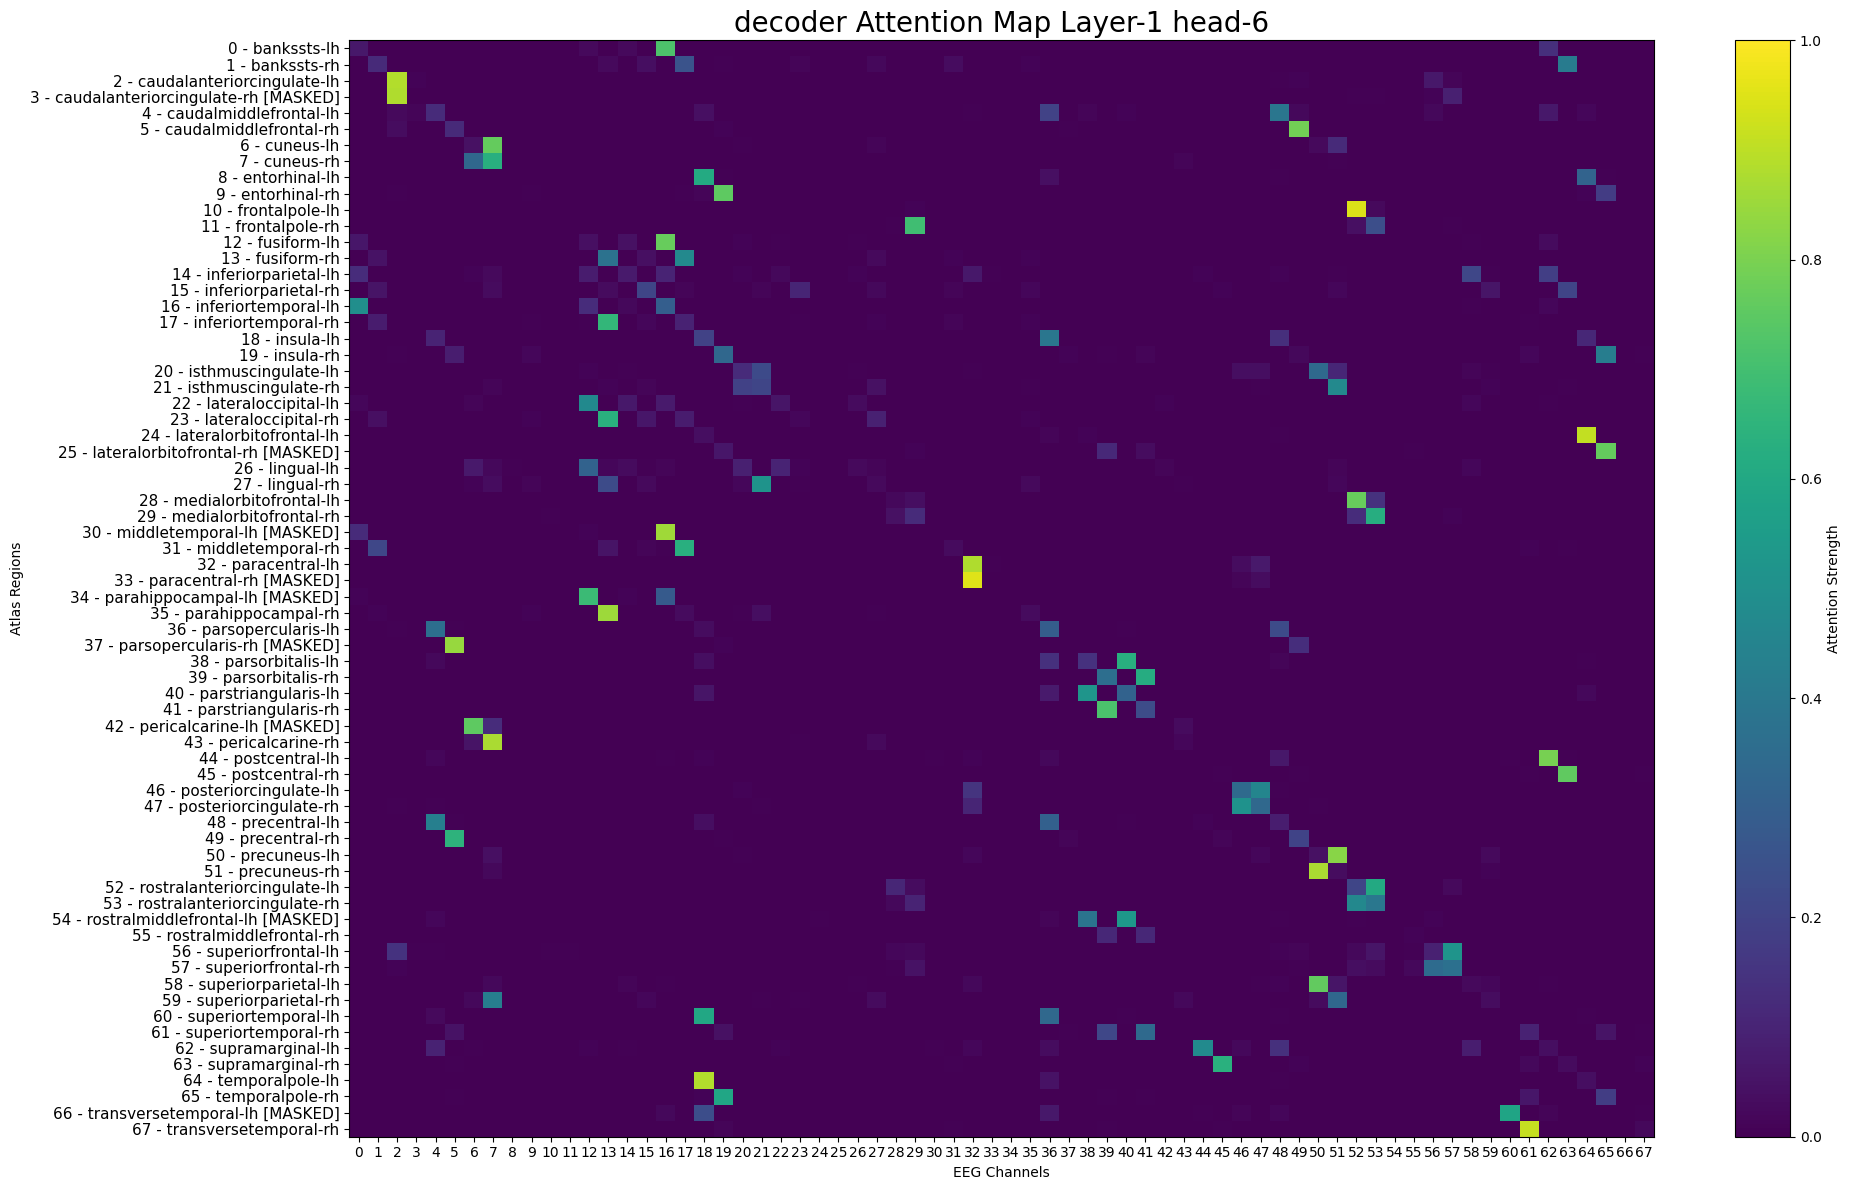

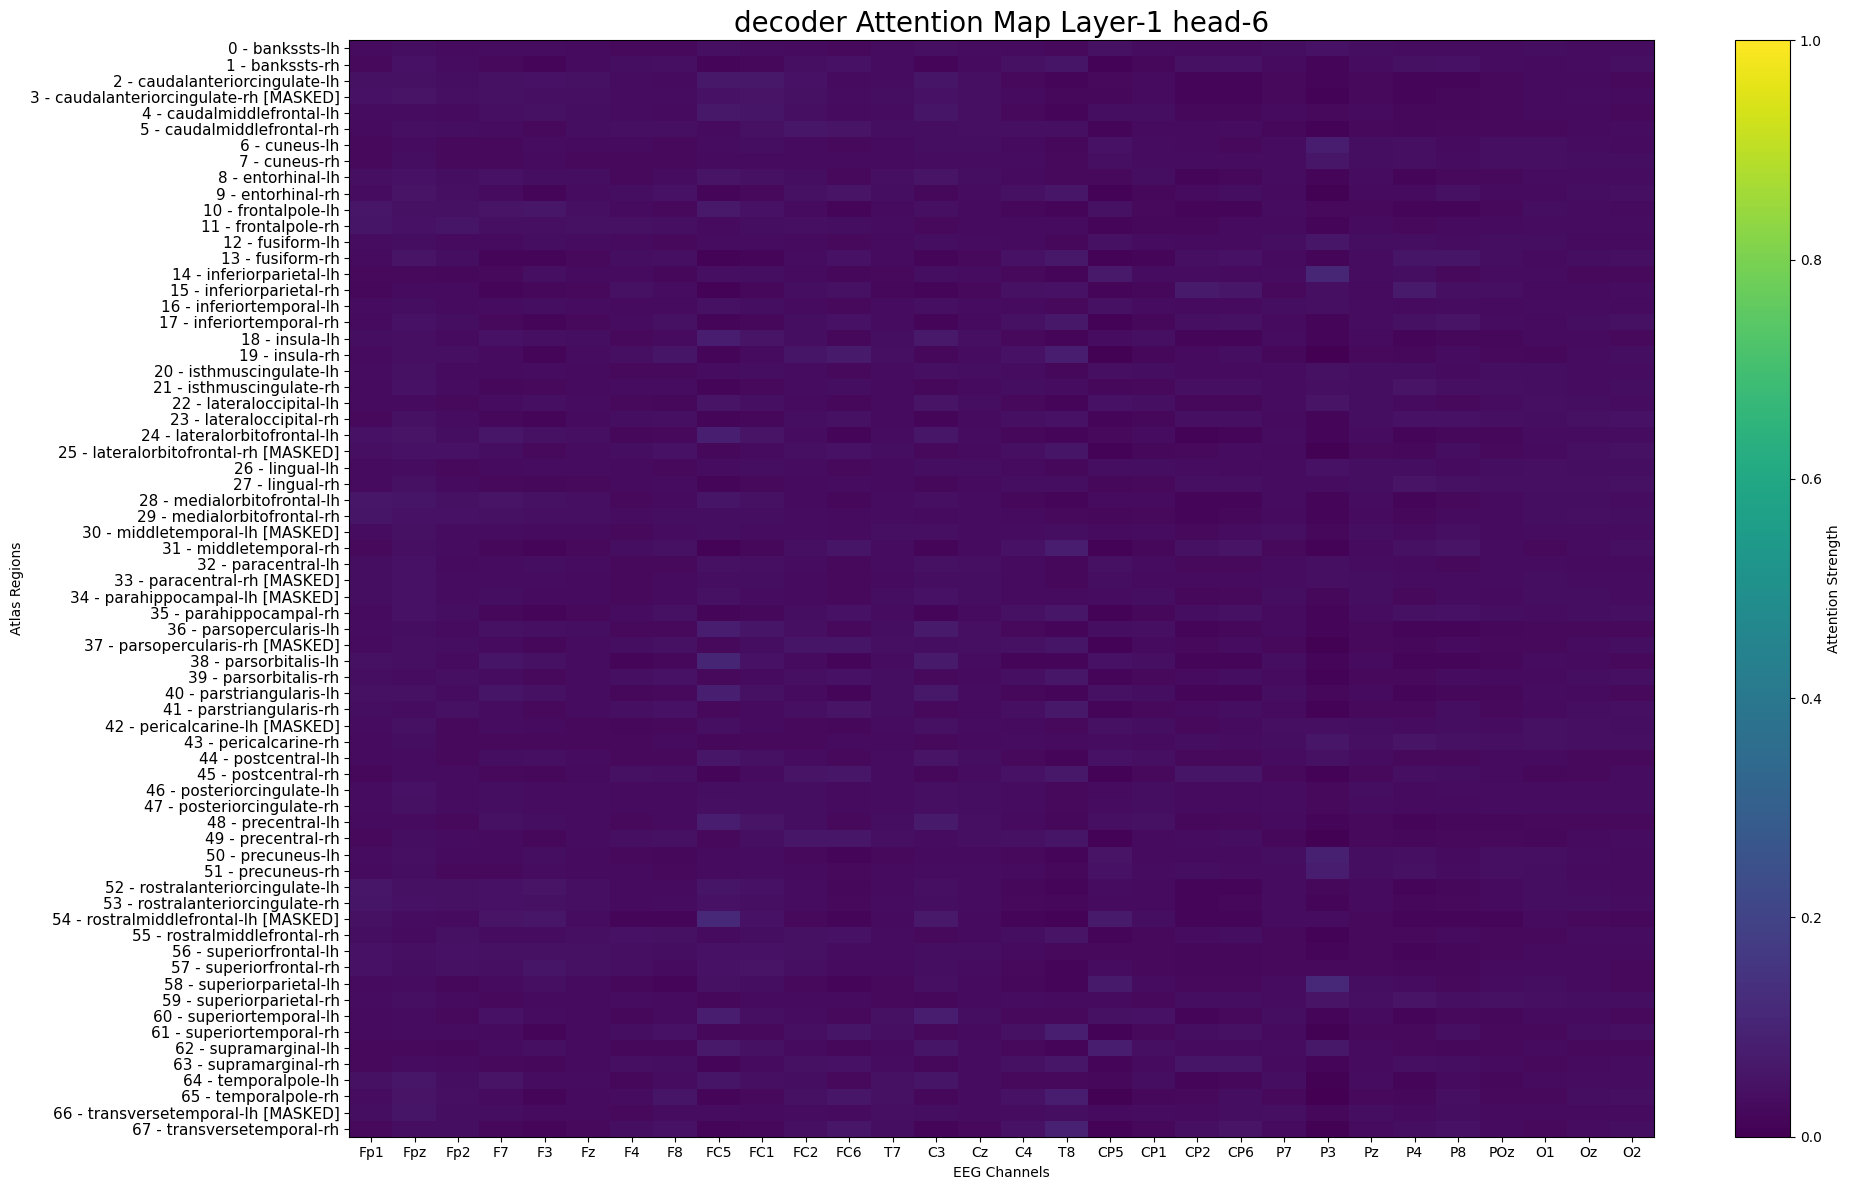

In [57]:
import json

def plot_map(atten_pca_list, x_tick_name, y_tick_name, tup):
    layer, head, coder = tup
    plt.figure(figsize=(20, 12))
    im = plt.imshow(atten_pca_list.cpu().numpy(), aspect='auto', cmap='viridis', vmin=0, vmax=1)

    cbar = plt.colorbar(im)
    cbar.set_label('Attention Strength')

    plt.xticks(ticks=range(len(x_tick_name)), labels=x_tick_name)
    plt.yticks(ticks=range(len(y_tick_name)), labels=y_tick_name, fontsize=11)

    plt.ylabel(f'Atlas Regions')
    plt.xlabel('EEG Channels')
    plt.title(f'{coder} Attention Map Layer-{layer} head-{head}', fontsize=20)
    plt.tight_layout()
    plt.show()

# Channels space information
with open('label_names.json', 'r') as f:
    label_names = json.load(f)
ch_names_32 = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 
                'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 
                'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

encoder_atten , decoder_atten = attention_map # tuple (encoder atten, decoder atten)
# decoder_atten # list of atten in Decoder layer (N list)

# for decoder_atten_1, decoder_atten_2 in decoder_atten:
    # print(decoder_atten_1.shape)        # decoder_atten_1 [b, head, source_seq, source_seq]
    # print(decoder_atten_2.shape)        # decoder_atten_1 [b, head, source_seq, sensor_seq]

# batch sample i
index = 10
# Layer[-1] attention map
layer = 1
first_decoder_atten_layer, second_decoder_atten_layer = decoder_atten[layer]
first_de_atten = first_decoder_atten_layer[index].squeeze(0)    # [1, 8, 204, 204] 
second_de_atten = second_decoder_atten_layer[index].squeeze(0)   # [1, 8, 204, 30]

first_encoder_atten_layer = encoder_atten[layer]

first_en_atten = first_encoder_atten_layer[index].squeeze(0)    # [1, 8, 30, 30] 

mask = batch['tgt_token_mask'][index].squeeze(0)  # (204,)
# Your atlas names (list of 204 strings)
atlas_names = [f"{label}" for label in label_names for i in range(1, 4)]

# Get only masked atlas names
masked_atlas_names = [name for m, name in zip(mask, atlas_names) if m]

for i in range(8):
    # Step 1: split the attention maps and labels
    first_atten_i = first_de_atten[i]     # [204, 204]
    second_atten_i = second_de_atten[i]    # [204, 30]

    first_atten_pca = first_atten_i[0::3, 0::3]
    second_atten_pca = second_atten_i[0::3, :]

    atlas_name_pca_list = [
        [atlas_names[idx] for idx in range(start, len(atlas_names), 3)]
        for start in range(3)
    ]

    # Step 2: also split the mask
    mask = mask.bool()  # ensure it's boolean
    mask_pca_list = [mask[start::3] for start in range(3)]  # PCA1, PCA2, PCA3 masks

    # Step 3: modify atlas names if masked
    atlas_name_with_mask_list = []
    for names, masks in zip(atlas_name_pca_list, mask_pca_list):
        new_names = []
        count = 0
        for name, m in zip(names, masks):
            if m:
                new_names.append(f"{count} - {name} [MASKED]")
            else:
                new_names.append(f"{count} - {name}")
            count = count+1
        atlas_name_with_mask_list.append(new_names)

    titles = ['PCA1', 'PCA2', 'PCA3']

    # plot decoder
    plot_map(first_atten_pca, range(0, len(atlas_name_with_mask_list[0])), atlas_name_with_mask_list[0], (layer, i, "decoder"))
    plot_map(second_atten_pca, ch_names_32, atlas_name_with_mask_list[0], (layer, i, "decoder"))

    # plot encoder
    plot_map(first_en_atten[i], ch_names_32, ch_names_32, (layer, i, "encoder"))


# SSVEP MNE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel

import mne

# Load raw data
data_path = mne.datasets.ssvep.data_path()
bids_fname = (
    data_path / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"
)

raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info["line_freq"] = 50.0

# Set montage
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference("average", projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design="firwin", verbose=False)

# Construct epochs
raw.annotations.rename({"Stimulus/S255": "12hz", "Stimulus/S155": "15hz"})
tmin, tmax = -1.0, 20.0  # in s
baseline = None
epochs = mne.Epochs(
    raw,
    event_id=["12hz", "15hz"],
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    preload=True,  # 加入這行
    verbose=False,
)
# Step 1: Downsample to 100 Hz
epochs.resample(100)

# Step 2: Crop to 20 seconds (去掉最後1秒，因為21秒無法整除2秒段數)
epochs.crop(tmin=0, tmax=20.0)

# Step 3: 將每個 trial 切成 10 段，每段 2 秒
segment_length = 2.0  # seconds
sfreq = epochs.info['sfreq']
samples_per_segment = int(segment_length * sfreq)

all_segments = []

for epoch in epochs.get_data():  # shape = (32, 2000)
    for i in range(10):
        start = i * samples_per_segment
        end = start + samples_per_segment
        segment = epoch[:, start:end]  # shape: (32, 200)
        all_segments.append(segment)

# Step 4: 組合成 numpy array，shape = (200, 32, 200)
data_array = np.stack(all_segments, axis=0)

In [ ]:
def do_fft(signals, sampling_rate = 100):

    # 計算 FFT
    stc_fft = np.fft.fft(signals, axis=2)
    stc_power_spectrum = np.abs(stc_fft) ** 2
    print(stc_power_spectrum.shape)

    # 計算頻率軸
    freqs = np.fft.fftfreq(signals.shape[2], d=1/sampling_rate)

    # 只取正頻率部分
    positive_freqs = freqs[:signals.shape[2] // 2]
    positive_power = stc_power_spectrum[:,:, :signals.shape[2] // 2]

    return positive_power, positive_freqs

fft_data, fft_freqs = do_fft(data_array, 100)
print(fft_data.shape)
show_fft(fft_data[40], x=8,y=4,z=20)

In [ ]:
show_fft(preds[0],x=17*3,z=32*3)

### SSVEP Tshing Hwa

In [ ]:
import scipy.io
import numpy as np
from scipy.signal import resample
import mne

mat = scipy.io.loadmat("G:\\共用雲端硬碟\\CNElab_陳昱祺\\source localization\\test_data\\tshinghwa\\tshinghwa\\S1.mat")

data = mat['data'][:,:,0,:]
print(data.shape)
data_new = np.transpose(data, (2, 0, 1))

def do_fft(signals, sampling_rate = 100):

    # 計算 FFT
    stc_fft = np.fft.fft(signals, axis=2)
    stc_power_spectrum = np.abs(stc_fft) ** 2
    print(stc_power_spectrum.shape)

    # 計算頻率軸
    freqs = np.fft.fftfreq(signals.shape[2], d=1/sampling_rate)

    # 只取正頻率部分
    positive_freqs = freqs[:signals.shape[2] // 2]
    positive_power = stc_power_spectrum[:,:, :signals.shape[2] // 2]

    return positive_power, positive_freqs

def get_channel_index():
    # 建立 channel map (只做一次)
    ch_names_64 = mne.io.read_raw('G:\\共用雲端硬碟\\CNElab_陳昱祺\\source localization\\test_raw.fif', verbose='Warning').resample(100).info['ch_names']
    ch_names_32 = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 
                'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 
                'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
    ch_idx_map = [ch_names_64.index(ch) for ch in ch_names_32]

    return ch_idx_map

import numpy as np
from scipy.signal import resample

# 假設 data 的 shape 是 (6, 64, 1500)
# 我們想要變成 (6, 64, 600)

data_downsampled = resample(data_new, 600, axis=2)  # 在 time 軸 (最後一維) downsample
# data_downsampled.shape == (6, 64, 600)
power, freq = do_fft(data_downsampled)

# 找出頻率 0Hz 到 49.5Hz，每隔 0.5Hz 的索引（共100個）
target_freqs = np.arange(0, 50, 0.5)  # [0, 0.5, 1.0, ..., 49.5]
target_indices = [np.argmin(np.abs(freq - f)) for f in target_freqs]

ch_idx = get_channel_index()
# print(ch_idx, target_indices)

# 取出對應的頻率成分
selected_fft = power[:, :, target_indices]  # shape: (6, 64, 100)
# 取出對應的頻率成分
selected_fft = selected_fft[:, ch_idx, :]  # shape: (6, 64, 100)

show_fft(selected_fft[0], x=17, z=32)